In [1]:
# A main concept in my model is classifying passengers based on
# information about their groups, whether its their family group
# or their ticket group.  This is inspired by the following kaggle
# notebook: 
# https://www.kaggle.com/cdeotte/titanic-using-name-only-0-81818
# The above notebook achieves strong results by classifying women to survive
# and men to die, except it predicts boys live when they are part of group
# in which all women and other children live, and it predicts women die when
# all other women and children in the group die.

# The goal of my notebook is to create a similar rule based model to the 
# example above, but to improve in certain areas, and to come to my own rule
# conclusions. Specifically, I want to be a bit more detail oriented in 
# breaking the passengers into distinct groups, and I want to  
# focus on classifications for passengers traveling alone where grouping by
# family is not applicable.  I explore whether families tend to have 
# survival heirarchies. For example, does a boy surviving imply that a girl
# will likely survive?  Will a man surviving imply that his wife is more 
# likely to survive?

# I use sklearn pipeline functionality in the beginning, but eventually just
# start using straight pandas for easy column name handling without having
# to write a large number of custom transformers.

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from pandas.api.types import CategoricalDtype
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SequentialFeatureSelector
import collections

# train_file is going to be split into train and test, and then the 
# resulting that model will be used to predict the test_file on kaggle

def load_data():
    """Loads the three files provided by Kaggle"""
    data_folder = Path(
#         'C:/Users/chris/OneDrive/Desktop/Machine Learning/Kaggle/titanic/')
        'C:/Users/chris/Machine Learning/Kaggle/titanic')

    gender_file = data_folder / 'gender_submission.csv'
    test_file = data_folder / 'test.csv'
    train_file = data_folder / 'train.csv'
                   
    sample_gender_submission = pd.read_csv(gender_file)
    test = pd.read_csv(test_file)
    train = pd.read_csv(train_file)
    
    return sample_gender_submission, test, train

In [3]:
def create_initial_datasets():
    _, test, train = load_data()
    x_train = train.drop(columns="Survived").copy()
    y_train = train["Survived"].copy()
    x_test = test
    
    return x_train, y_train, x_test

In [4]:
class DropColumns(BaseEstimator, TransformerMixin):
    """Drops specified list of columns from train or test dataframe"""
    
    def __init__(self, cols_to_drop):
        self.cols_to_drop = cols_to_drop
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        X = X.drop(columns=self.cols_to_drop)
        
        return X

In [5]:
class TitleExtractor(BaseEstimator, TransformerMixin):
    """Extracts title from name variable"""
    
    def __init__(self, copy=True):
        self.copy = copy
        
    def fit(self, X, y=None):
        self.n_features_in = 1
        
        return self

    def get_title(name):
        title = next(filter(lambda x: "." in x, str(name).split()))
        return title
    
    def transform(self, X):
        name_raw = X.copy()
        title =  name_raw.apply(TitleExtractor.get_title)
        title = pd.DataFrame(title)
        
        return title 

In [6]:
class CabinExtractor(BaseEstimator, TransformerMixin):
    """Extracts first letter appearing in cabin series."""
    
    def __init__(self, copy=True):
        self.copy = copy
    
    def fit(self, X, y=None):
        return self
    
    def first_letter(cabin):
        if type(cabin) == str:
            letter = next(filter(lambda x: x.isalpha(), cabin))
            return letter

    def transform(self, X):
        cabin_raw = X.copy()
        cabin_letters = cabin_raw.apply(CabinExtractor.first_letter)
        cabin_letters = pd.DataFrame(cabin_letters)
        
        return cabin_letters

In [7]:
# Here I am creating the pipelines that will be part of the column 
# transformer.  I have to specify the categories because in both title and
# cabin, train and test each have values unseen in the other set.  
# Without presetting labels, the transformed train and test sets would have 
# a different number of columns and predicting would be impossible.

def get_title_values(x_train, x_test):
    te = TitleExtractor()
    train_titles = np.unique(te.transform(x_train.Name))
    test_titles = np.unique(te.transform(x_test.Name))
    title_values = np.unique(np.concatenate([train_titles, test_titles]))
    
    return title_values

x_train, y_train, x_test = create_initial_datasets()

title_values = get_title_values(x_train, x_test)
title_pipe = Pipeline([("title extractor", TitleExtractor()),
                       ("title dummy encoder", OneHotEncoder(
                           categories = [title_values],
                           handle_unknown='ignore'))])

cab_categories = np.array(["T", "A", "B", "C", "D", "E", "F", "G"])
cabin_pipe = Pipeline([("cabin extractor", CabinExtractor()),
                       ("ordinal encoder", OrdinalEncoder(
                           categories=[cab_categories], handle_unknown=
                           'use_encoded_value', unknown_value=np.nan))])

sex_values = np.array(["male", "female"])

embarked_values = np.array(["S", "C", "Q"])

In [8]:
# creating the column transformer that will implement sklearn encoders and
# custom transformers

ct = ColumnTransformer(
    [("title pipe", title_pipe, "Name"),
     ("cabin pipe", cabin_pipe, "Cabin"),
     ("sex encoder", OrdinalEncoder(
         categories=[sex_values]), ["Sex"]),
     ("embarked encoder", OneHotEncoder(
         categories=[embarked_values], handle_unknown='ignore'),
      ["Embarked"])],
    remainder='passthrough')

In [9]:
# preprocessor drops unused columns and then uses the column transsformer

preprocessor = Pipeline(
    [("drop columns", DropColumns(["PassengerId"])),
     ("column transformer", ct)])

In [10]:
# transforming the train and test sets, output is arrays

x_train_transformed = preprocessor.fit_transform(x_train)
x_test_transformed = preprocessor.fit_transform(x_test)

In [11]:
# Now, I want to specify the columns of the transformed train and test
# arrays and create dataframes.  Because I did not implement 
# get_feature_names_out and related methods in my custom transformers,
# this must be done manually.

# the order of the original_columns list is based on the order I processed
# variables in the column_transformer.  Name, Cabin, Sex and Embarked are
# first, and then the passthrough columns in the order they appeared in the 
# original dataset
original_columns = ["Name", "Cabin", "Sex", "Embarked", "Pclass", "Age", 
                    "SibSp", "Parch", "Ticket","Fare"]

#The different title categories contained in test and train
name_columns = list(preprocessor.steps[1][1].transformers[0][1].\
             steps[1][1].categories[0])

# The different embarked categories in test and train.  This is set for the 
# purpose of handling nan values, seen in train but not test
embarked_columns = list(preprocessor.steps[1][1].transformers[3][1].\
                        categories[0])

In [12]:
# The following three functions create the labels of the transformed train
# and test dataframes
def get_nested_column_names(original_columns, name_columns, 
                                 embarked_columns):
    transformed_names = original_columns.copy()
    name_columns = name_columns.copy()
    embarked_columns = embarked_columns.copy()
    name_index = transformed_names.index("Name")
    embarked_index = transformed_names.index("Embarked")
    transformed_names.remove("Name")
    transformed_names.insert(name_index, name_columns)
    transformed_names.remove("Embarked")
    transformed_names.insert(embarked_index, embarked_columns)
    
    return transformed_names

In [13]:
def flatten_transformed_names(transformed_names):
    flat_columns = list()
    for item in transformed_names:
        if type(item) == str:
            flat_columns.append(item)
        elif type(item) == list:
            for element in item:
                flat_columns.append(element)
        else:
            pass
   
    return flat_columns

In [14]:
def get_transformed_column_names(original_columns, name_columns, 
                                 embarked_columns):
    transformed_names = get_nested_column_names(
        original_columns, name_columns, embarked_columns)
    
    flat_transformed_names = flatten_transformed_names(transformed_names)
    
    return flat_transformed_names

In [15]:
# creating the train and test transformed dataframes
transformed_column_names = get_transformed_column_names(
    original_columns, name_columns, embarked_columns)


x_train_transformed_df = pd.DataFrame(x_train_transformed, 
                          columns=transformed_column_names)
x_test_transformed_df = pd.DataFrame(x_test_transformed,
                          columns=transformed_column_names)

# casting all column types to str
x_train_transformed_df.columns = x_train_transformed_df.columns.astype(str)
x_test_transformed_df.columns = x_test_transformed_df.columns.astype(str)

In [16]:
# From this point on, I will be doing transformations in pandas.  Ideally, 
# everything would be wrapped up in custom transformers in a big pipeline, 
# but I do not yet know how to fully support get_feature_names_out, 
# so for simplicity I am relying on pandas.

In [17]:
train_transformed = pd.concat([x_train_transformed_df, y_train], axis=1)

In [18]:
# Adding the family_members feature (# of family members not including the 
# passenger themselves)
train_transformed["family_members"] = train_transformed["SibSp"] + \
    train_transformed["Parch"]
x_test_transformed_df["family_members"] = x_test_transformed_df["SibSp"] +\
    x_test_transformed_df["Parch"]

In [19]:
# Adding the family_size variable, which counts the current passenger.  
# This is based on the family_members variable, which excludes the current 
# passenger.  Both variables will be convenient to have for different 
# calculations
train_transformed["family_size"] = train_transformed["family_members"] + 1
x_test_transformed_df["family_size"] = x_test_transformed_df[
    "family_members"] + 1

In [20]:
# Adding the Lname variable
train_transformed["lname"] = x_train["Name"].copy().apply(lambda x: str(x).split()[0].replace(',', ''))
x_test_transformed_df["lname"] = x_test["Name"].copy().apply(lambda x: str(x).split()[0].replace(',', ''))

In [21]:
# Adding the true_family_size variable.  This is the total number of 
# passengers with the same last name observed in train and test combined.
# This is different than family_members and family_size, which are both 
# based on Parch and SibSp

# First step is to counts the occurences of each last name in a dictionary
lname_train_test = train_transformed["lname"].append(
    x_test_transformed_df["lname"])
lname_counts = lname_train_test.value_counts().to_dict()

# Adding the lname counts to each passenger
train_transformed["true_family_size"] = train_transformed[
    "lname"].copy().apply(lambda x: lname_counts.get(x))

x_test_transformed_df["true_family_size"] = x_test_transformed_df[
    "lname"].copy().apply(lambda x: lname_counts.get(x))

In [22]:
# Adding the ticket_totals variable (necessary for calculating fare)

# appending the train and test ticket columns
train_test_ticket = train_transformed["Ticket"].append(
    x_test_transformed_df["Ticket"])

# putting the number of occurences for each ticket in a dictionary
ticket_totals =  train_test_ticket.value_counts().to_dict()

# Creating the ticket_totals variable for each passenger (total people 
# including the passenger who shared their ticket number)
train_transformed["ticket_totals"] = train_transformed["Ticket"].copy\
    ().apply(lambda x: ticket_totals.get(x))
x_test_transformed_df["ticket_totals"] = x_test_transformed_df[
    "Ticket"].copy().apply(lambda x: ticket_totals.get(x))

In [23]:
# Recalculating fare: divide fare by number of passengers sharing the ticket
# across train and test datasets


# According to encyclopedia titanica, there were 1317 passengers aboard the 
# titanic, and train and test combined have a 1309 passengers.  Therefore, 
# calculated rates fares should be accurate with a few exceptions.

# My fare calculations assume each all passengers sharing a common ticket 
# number have the same fare, which may be wrong in some cases.  This could
# be done in more depth, but I am going to let it be.

train_transformed["fare_calculated"] = train_transformed["Fare"] / \
    train_transformed["ticket_totals"]
x_test_transformed_df["fare_calculated"] = x_test_transformed_df["Fare"] / \
    x_test_transformed_df["ticket_totals"]

In [24]:
# Splitting the fare into seperate columns based on port of embarktion
# Creating the feature combinations of fare and embarktion port
train_transformed["c_fare"] = \
    train_transformed["C"]*train_transformed["fare_calculated"]
train_transformed["q_fare"] = \
    train_transformed["Q"]*train_transformed["fare_calculated"]
train_transformed["s_fare"] = \
    train_transformed["S"]*train_transformed["fare_calculated"]

train_transformed[["c_fare", "q_fare", "s_fare"]] = train_transformed[
    ["c_fare", "q_fare", "s_fare"]].replace(0, np.nan)


x_test_transformed_df["c_fare"] = \
    x_test_transformed_df["C"]*x_test_transformed_df["fare_calculated"]
x_test_transformed_df["q_fare"] = \
    x_test_transformed_df["Q"]*x_test_transformed_df["fare_calculated"]
x_test_transformed_df["s_fare"] = \
    x_test_transformed_df["S"]*x_test_transformed_df["fare_calculated"]

x_test_transformed_df[["c_fare", "q_fare", "s_fare"]] = \
    x_test_transformed_df[["c_fare", "q_fare", "s_fare"]].replace(0, np.nan)

In [25]:
c_fare_df = train_transformed[["c_fare", "Survived"]].copy()
q_fare_df = train_transformed[["q_fare", "Survived"]].copy()
s_fare_df = train_transformed[["s_fare", "Survived"]].copy()

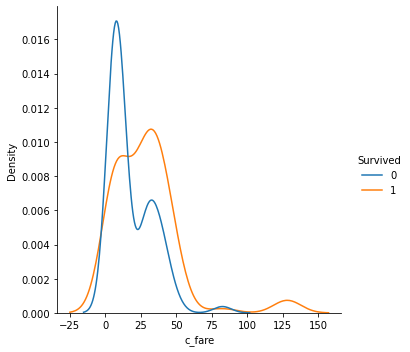

In [26]:
# Fare distributions of surviving and dying passengers from c port
sns.displot(c_fare_df, x="c_fare", hue="Survived", kind="kde")

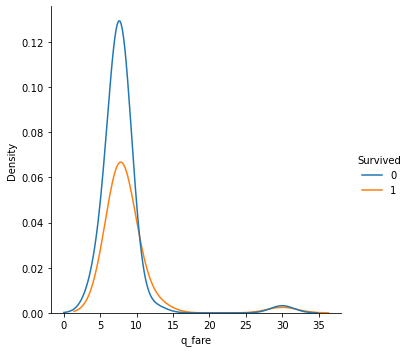

In [27]:
# Fare distributions of surviving and dying passengers from q port
sns.displot(q_fare_df, x="q_fare", hue="Survived", kind="kde")

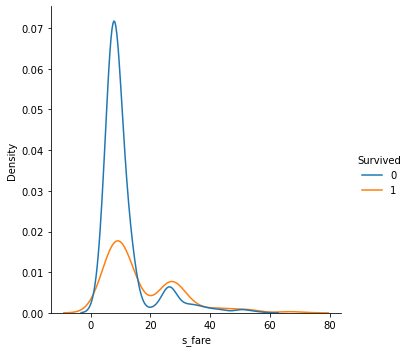

In [28]:
# Fare distributions of surviving and dying passengers from s port
sns.displot(s_fare_df, x="s_fare", hue="Survived", kind="kde")

In [29]:
c_fare_df.groupby("Survived").mean()

,c_fare
Survived,
0,18.001647
1,28.531056


In [30]:
q_fare_df.groupby("Survived").mean()

,q_fare
Survived,
0,7.967730
1,8.837227


In [31]:
s_fare_df.groupby("Survived").mean()

,s_fare
Survived,
0,11.062544
1,17.004991


In [32]:
# These plots and survival means are evidence in favor of splitting the fare
# variable into three variables based on port of embarktion.  
# The three ports each have distinct distributions of fare for passengers
# who survived and for those who died

# Specifically, the q port had similar fare distributions for those who 
# lived and those who died.

# The average survivor in groups c and s has a fair ~1.55 times that of the
# average dead passenger, and the mean survivor and dead passenger from 
# port c have fares ~1.64 higher than survivors and dead passengers from s

In [33]:
# It is also possible that Pclass is the more important variable to combine
# to combine with Fare.  Lets look at the similar relationships between 
# different passenger classes, fare, and survival

In [34]:
Pclass_fare_calculated_df = train_transformed[
    ["fare_calculated", "Pclass", "Survived"]].copy()

In [35]:
# median fares of all pclasses by survival
Pclass_fare_calculated_df.groupby(["Pclass", "Survived"]).median()

fare_calculated
Pclass Survived                 
1      0                  29.700
       1                  30.000
2      0                  12.875
       1                  12.000
3      0                   7.750
       1                   7.750

In [36]:
# Survival percentages by Pclass
Pclass_fare_calculated_df.groupby(["Pclass"]).mean()

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


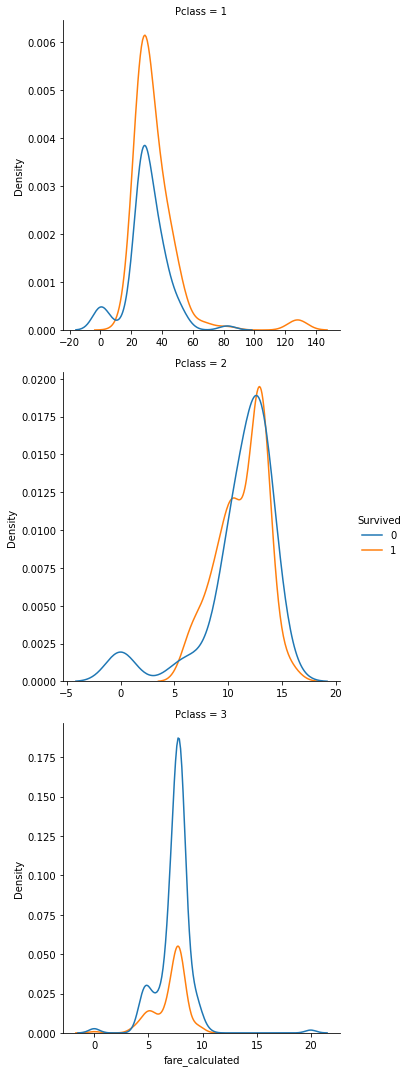

In [37]:
# Death and Survival fare distributions by Pclass
sns.displot(Pclass_fare_calculated_df, x="fare_calculated", row="Pclass",
            hue="Survived", kind="kde", legend=True, facet_kws=
            {'sharex':False, 'sharey':False})

In [38]:
# There does not seem to be meaningful seperation in fares between those 
# that died and those that lived within each seperate Pclass.  This 
# reinforces that combining fare with port is more meaningful than combining
# fare with Pclass, although Pclass is an important variable on its own.

In [39]:
# Adding a variables for family max age and family min age

# Creating a df of last names and ages for the combined train and test set
lname_age_df = pd.concat(
    [train_transformed[["lname", "Age"]].copy(), 
     x_test_transformed_df[["lname", "Age"]].copy()]).reset_index().drop(
     columns="index")

In [40]:
# creating dictionaries of the min and max age for each last name
lname_age_min = lname_age_df.groupby("lname").min().squeeze()
lname_age_max = lname_age_df.groupby("lname").max().squeeze()
min_ages = dict()
max_ages = dict()
for index, value in lname_age_min.iteritems():
    min_ages[index] = value
for index, value in lname_age_max.iteritems():
    max_ages[index] = value

In [41]:
# Creating the lname_min_age and lname_max_age variables

# Adding the lname_min_age for train and test 
train_transformed["lname_min_age"] = train_transformed["lname"].apply(
    lambda x: min_ages.get(x))
x_test_transformed_df["lname_min_age"] = x_test_transformed_df[
    "lname"].apply(lambda x: min_ages.get(x))

# Adding the lname_max_age for train and test
train_transformed["lname_max_age"] = train_transformed["lname"].apply(
    lambda x: max_ages.get(x))
x_test_transformed_df["lname_max_age"] = x_test_transformed_df[
    "lname"].apply(lambda x: max_ages.get(x))

In [42]:
# combining train and test to look at lname and family_members
train_test_super = pd.concat(
    [train_transformed[["lname", "family_members"]], 
     x_test_transformed_df[["lname", "family_members"]]
    ]).reset_index().drop(columns = "index")

In [43]:
# For 814 of 866 lnames, each passenger has the same amount of 
# family_members as every other passenger sharing that lname, which
# is calculated using SibSp and Parch.  This means the family probably does
# not have relatives traveling with them. For passengers in these families,
# we can make further adulthood classifications using sibsp and parch along
# with the calculated family_members variable, because we know the 
# family_members variable is the same for each family member.  This
# information will be used to create the "simple_family" variable.  
# Simple_family == 1 will mean all passengers sharing the current passengers
# lname share each have the same amount of family members. 

# We have to keep in mind that passengers with no family members are 
# automatically counted as simple_family == 1, so this will skew the data.
# The ratio of passengers who have at least one family member that have
# simple_family == 1 will be lower than 814/866 due to the skew from the 
# single passengers.

train_test_super.groupby("lname").nunique().value_counts()

family_members
1                 814
2                  48
3                   3
4                   1
dtype: int64

In [44]:
# putting number of unique family_members values per last name into a dict
lname_uniques = train_test_super.groupby(
    "lname").nunique().squeeze().to_dict()

In [45]:
# Setting train and test to the value of the dictionary for each last 
# name key
train_transformed["simple_family"] = train_transformed["lname"].apply(
    lambda x: lname_uniques.get(x))
x_test_transformed_df["simple_family"] = x_test_transformed_df[
    "lname"].apply(lambda x: lname_uniques.get(x))

In [46]:
# updating the values of simple_family.  If the value is not 1, we set it to
# 0.  This now becomes a binary variable where 1 means each passenger of 
# an lname has the same number of family_members, and 0 means there are at 
# least two different family_members values for passengers within the given
# last name.
train_transformed.loc[
    (train_transformed["simple_family"] != 1), "simple_family"] = 0
x_test_transformed_df.loc[
    (x_test_transformed_df["simple_family"] != 1), "simple_family"] = 0

In [47]:
# train simple_family breakdown
train_transformed["simple_family"].value_counts()

1    748
0    143
Name: simple_family, dtype: int64

In [48]:
# test simple_family breakdown
x_test_transformed_df["simple_family"].value_counts()

1    360
0     58
Name: simple_family, dtype: int64

In [49]:
# adult classification rules


# global rules:

# 1) By default, classify all passengers as adult
# 2) if parch >= 1, classify all miss as child
# 3) classify all master as child
# 4) if age < 18, classify as child


# additional rules for when simple_family = 1:

# family_members = 0 -> no additional rules
# family_members = 1 -> if parch = 1 and age = lname_min_age, classify 
#    child.
# family_members = 2 -> no additional rules.  
# family_members = 3 -> No additional rules.
# family_members = 4 or greater -> if parch = 1 or 2, classify as child.  
#    When parch >= 1, we know it is a family unit, and adults will have 
#    parch at least 3.


# These additional rules are meant to fill in the gaps of the global rules.
#    Specifically, they will catch some Mr. titled passengers who are above
#    18 or whose age is nan, but are the children in their family groups.
#    This is not many passengers, but I may as well be thorough.

In [50]:
# First, assigning based on the global rules

In [51]:
# Setting adult to 1 by default.  Adult = 0 will signify children.
train_transformed["adult"] = 1
x_test_transformed_df["adult"] = 1

In [52]:
# Setting miss passengers to child if parch >= 1
train_transformed.loc[
    (train_transformed["Miss."] == 1) &
    (train_transformed["Parch"] >= 1), ["adult"]] = 0
x_test_transformed_df.loc[
    (x_test_transformed_df["Miss."] == 1) &
    (x_test_transformed_df["Parch"] == 1), ["adult"]] = 0

In [53]:
# Setting all master passengers to child
train_transformed.loc[train_transformed["Master."] == 1, ["adult"]] = 0
x_test_transformed_df.loc[x_test_transformed_df["Master."] == 1, 
                          ["adult"]] = 0

In [54]:
# Setting all passengers whose age is under 18 to child
train_transformed.loc[train_transformed["Age"] < 18, ["adult"]] = 0
x_test_transformed_df.loc[x_test_transformed_df["Age"] < 18, ["adult"]] = 0

In [55]:
# Now for the additional rules

In [56]:
# Assigning simple_family = 1, family_members = 1, parch = 1, and 
# age == lname_min_age to child
train_transformed.loc[
    (train_transformed["simple_family"] == 1) &
    (train_transformed["family_members"] == 1) &
    (train_transformed["Parch"] == 1) &
    (train_transformed["Age"] == train_transformed["lname_min_age"]), 
    ["adult"]] = 0
x_test_transformed_df.loc[
    (x_test_transformed_df["simple_family"] == 1) &
    (x_test_transformed_df["family_members"] == 1) &
    (x_test_transformed_df["Parch"] == 1) & 
    (x_test_transformed_df["Age"] == x_test_transformed_df[
        "lname_min_age"]), ["adult"]] = 0

In [57]:
# Assigning simple_family = 1, family_members >= 4, parch == 1 or 2 to 
# child
train_transformed.loc[
    (train_transformed["simple_family"] == 1) &
    (train_transformed["family_members"] >= 4) & 
    (train_transformed["Parch"].isin([1,2])), ["adult"]] = 0
x_test_transformed_df.loc[
    (x_test_transformed_df["simple_family"] == 1) & 
    (x_test_transformed_df["family_members"] >= 4) & 
    (x_test_transformed_df["Parch"].isin([1,2])), ["adult"]] = 0 

In [58]:
# Now, to count the survivals and deaths per family for adult and child 
# males and females

# This information will enable me to examine the effect of family 
# heirarchies on passenger survival

In [59]:
group_survival_df = train_transformed[
    ["adult", "lname", "Sex", "Survived"]].copy()

In [60]:
# Creating columns for women (adult females) who survived and died

# creating a dictionary for the number of women in train who survived per 
# last name
women_survived_dict = group_survival_df[
    (group_survival_df["Sex"] == 1) & 
    (group_survival_df["adult"] == 1)][
    ["lname", "Survived"]].groupby("lname").sum().squeeze().to_dict()

# creating a dictionary for the total number of women present in train 
# per last name
women_total_dict = group_survival_df[
    (group_survival_df["Sex"] == 1) & 
    (group_survival_df["adult"] == 1)][
    ["lname", "Survived"]].groupby("lname").count().squeeze().to_dict()

# Creating the women_survived column in train and test
train_transformed["women_survived"] = train_transformed["lname"].apply(
    lambda x: women_survived_dict.get(x)).fillna(0)

x_test_transformed_df["women_survived"] = x_test_transformed_df[
    "lname"].apply(lambda x: women_survived_dict.get(x)).fillna(0)

# creating the women_total column in train and test
train_transformed["women_total"] = train_transformed["lname"].apply(
    lambda x: women_total_dict.get(x)).fillna(0)

x_test_transformed_df["women_total"] = x_test_transformed_df[
    "lname"].apply(lambda x: women_total_dict.get(x)).fillna(0)

# creating the women_died column in train and test
train_transformed["women_died"] = train_transformed["women_total"] - \
    train_transformed["women_survived"]
x_test_transformed_df["women_died"] = x_test_transformed_df["women_total"] \
    - x_test_transformed_df["women_survived"]

In [61]:
# Creating columns for men (adult males) who survived and died

# creating a dictionary for the number of men in train who survived per 
# last name
men_survived_dict = group_survival_df[
    (group_survival_df["Sex"] == 0) & 
    (group_survival_df["adult"] == 1)][
    ["lname", "Survived"]].groupby("lname").sum().squeeze().to_dict()

# creating a dictionary for the total number of men present in train 
# per last name
men_total_dict = group_survival_df[
    (group_survival_df["Sex"] == 0) & 
    (group_survival_df["adult"] == 1)][
    ["lname", "Survived"]].groupby("lname").count().squeeze().to_dict()

# Creating the men_survived column in train and test
train_transformed["men_survived"] = train_transformed["lname"].apply(
    lambda x: men_survived_dict.get(x)).fillna(0)

x_test_transformed_df["men_survived"] = x_test_transformed_df[
    "lname"].apply(lambda x: men_survived_dict.get(x)).fillna(0)

# creating the men_total column in train and test
train_transformed["men_total"] = train_transformed["lname"].apply(
    lambda x: men_total_dict.get(x)).fillna(0)

x_test_transformed_df["men_total"] = x_test_transformed_df[
    "lname"].apply(lambda x: men_total_dict.get(x)).fillna(0)

# creating the men_died column in train and test
train_transformed["men_died"] = train_transformed["men_total"] - \
    train_transformed["men_survived"]
x_test_transformed_df["men_died"] = x_test_transformed_df["men_total"] \
    - x_test_transformed_df["men_survived"]

In [62]:
# Creating columns for girls (female children) who survived and died

# creating a dictionary for the number of girls in train who survived per 
# last name
girls_survived_dict = group_survival_df[
    (group_survival_df["Sex"] == 1) & 
    (group_survival_df["adult"] == 0)][
    ["lname", "Survived"]].groupby("lname").sum().squeeze().to_dict()

# creating a dictionary for the total number of girls present in train 
# per last name
girls_total_dict = group_survival_df[
    (group_survival_df["Sex"] == 1) & 
    (group_survival_df["adult"] == 0)][
    ["lname", "Survived"]].groupby("lname").count().squeeze().to_dict()

# Creating the girls_survived column in train and test
train_transformed["girls_survived"] = train_transformed["lname"].apply(
    lambda x: girls_survived_dict.get(x)).fillna(0)

x_test_transformed_df["girls_survived"] = x_test_transformed_df[
    "lname"].apply(lambda x: girls_survived_dict.get(x)).fillna(0)

# creating the girls_total column in train and test
train_transformed["girls_total"] = train_transformed["lname"].apply(
    lambda x: girls_total_dict.get(x)).fillna(0)

x_test_transformed_df["girls_total"] = x_test_transformed_df[
    "lname"].apply(lambda x: girls_total_dict.get(x)).fillna(0)

# creating the girls_died column in train and test
train_transformed["girls_died"] = train_transformed["girls_total"] - \
    train_transformed["girls_survived"]
x_test_transformed_df["girls_died"] = x_test_transformed_df["girls_total"] \
    - x_test_transformed_df["girls_survived"]

In [63]:
# Creating columns for boys (male children) who survived and died

# creating a dictionary for the number of boys in train who survived per 
# last name
boys_survived_dict = group_survival_df[
    (group_survival_df["Sex"] == 0) & 
    (group_survival_df["adult"] == 0)][
    ["lname", "Survived"]].groupby("lname").sum().squeeze().to_dict()

# creating a dictionary for the total number of boys present in train 
# per last name
boys_total_dict = group_survival_df[
    (group_survival_df["Sex"] == 0) & 
    (group_survival_df["adult"] == 0)][
    ["lname", "Survived"]].groupby("lname").count().squeeze().to_dict()

# Creating the boys_survived column in train and test
train_transformed["boys_survived"] = train_transformed["lname"].apply(
    lambda x: boys_survived_dict.get(x)).fillna(0)

x_test_transformed_df["boys_survived"] = x_test_transformed_df[
    "lname"].apply(lambda x: boys_survived_dict.get(x)).fillna(0)

# creating the boys_total column in train and test
train_transformed["boys_total"] = train_transformed["lname"].apply(
    lambda x: boys_total_dict.get(x)).fillna(0)

x_test_transformed_df["boys_total"] = x_test_transformed_df[
    "lname"].apply(lambda x: boys_total_dict.get(x)).fillna(0)

# creating the boys_died column in train and test
train_transformed["boys_died"] = train_transformed["boys_total"] - \
    train_transformed["boys_survived"]
x_test_transformed_df["boys_died"] = x_test_transformed_df["boys_total"] \
    - x_test_transformed_df["boys_survived"]

In [64]:
# At this point, we have included the current passenger in the train test in
# the count of survived or died passengers of each age & gender group.  We 
# do not want to know this information when making a prediction, and the 
# passengers in test do not benefit from this information, so we have to 
# adjust the counts to subtract the current passenger from the appropriate
# survival or death column.

In [65]:
# Adjusting group survival count for surviving male adults.
train_transformed.loc[
    (train_transformed["Sex"] == 0) & 
    (train_transformed["adult"] == 1) &
    (train_transformed["Survived"] == 1), 
    ["men_survived", "men_total"]] -= 1

# Adjusting group survival count for dying male adults.
train_transformed.loc[
    (train_transformed["Sex"] == 0) & 
    (train_transformed["adult"] == 1) &
    (train_transformed["Survived"] == 0), 
    ["men_died", "men_total"]] -= 1

In [66]:
# Adjusting group survival count for surviving male children
train_transformed.loc[
    (train_transformed["Sex"] == 0) &
    (train_transformed["adult"] == 0) &
    (train_transformed["Survived"] == 1),
    ["boys_survived", "boys_total"]] -= 1

# Adjusting group survival count for dying male children
train_transformed.loc[
    (train_transformed["Sex"] == 0) &
    (train_transformed["adult"] == 0) &
    (train_transformed["Survived"] == 0),
    ["boys_died", "boys_total"]] -= 1

In [67]:
# Adjusting group survival count for surviving female adults
train_transformed.loc[
    (train_transformed["Sex"] == 1) &
    (train_transformed["adult"] == 1) &
    (train_transformed["Survived"] == 1),
    ["women_survived", "women_total"]] -= 1

# Adjusting group survival count for dying female adults
train_transformed.loc[
    (train_transformed["Sex"] == 1) &
    (train_transformed["adult"] == 1) &
    (train_transformed["Survived"] == 0),
    ["women_died", "women_total"]] -= 1

In [68]:
# Adjusting group survival count for surviving female children
train_transformed.loc[
    (train_transformed["Sex"] == 1) &
    (train_transformed["adult"] == 0) &
    (train_transformed["Survived"] == 1),
    ["girls_survived", "girls_total"]] -= 1

# Adjusting group survival count for dying female children
train_transformed.loc[
    (train_transformed["Sex"] == 1) &
    (train_transformed["adult"] == 0) &
    (train_transformed["Survived"] == 0),
    ["girls_died", "girls_total"]] -= 1

In [69]:
# For the passengers traveling alone, which make up 60% of the train set, 
# predicting survival based on family member survival is not possible.
len(train_transformed[train_transformed["family_members"] == 0]) / \
len(train_transformed)

0.6026936026936027

In [70]:
# Therefore, we can go for the next best thing, which is predicting their 
# survival based off of the survival outcomes of the other passengers in 
# their ticket group from passengers in the train set.

In [71]:
# Creating a subset df to extract features from
train_ticket_df = train_transformed[
    ["Ticket", "adult", "Sex", "Survived"]].copy()

In [72]:
# creating a dict for men who survived per ticket number
ticket_men_survived_dict = train_ticket_df[
    (train_ticket_df["adult"] == 1) &
    (train_ticket_df["Sex"] == 0) &
    (train_ticket_df["Survived"] == 1)]["Ticket"].value_counts().to_dict()

# creating a dict for men who died per ticket number
ticket_men_died_dict = train_ticket_df[
    (train_ticket_df["adult"] == 1) &
    (train_ticket_df["Sex"] == 0) &
    (train_ticket_df["Survived"] == 0)]["Ticket"].value_counts().to_dict()

# Creating the ticket_men_survived column in train and test
train_transformed["ticket_men_survived"] = \
    train_transformed["Ticket"].apply(
    lambda x: ticket_men_survived_dict.get(x)).fillna(0)

x_test_transformed_df["ticket_men_survived"] = \
    x_test_transformed_df["Ticket"].apply(
    lambda x: ticket_men_survived_dict.get(x)).fillna(0)

# Creating the ticket_men_died column in train and test
train_transformed["ticket_men_died"] = \
    train_transformed["Ticket"].apply(
    lambda x: ticket_men_died_dict.get(x)).fillna(0)
x_test_transformed_df["ticket_men_died"] = \
    x_test_transformed_df["Ticket"].apply(
    lambda x: ticket_men_died_dict.get(x)).fillna(0)

# Creating the ticket_men_total column in train and test
train_transformed["ticket_men_total"] = \
    train_transformed["ticket_men_survived"] + \
    train_transformed["ticket_men_died"]

x_test_transformed_df["ticket_men_total"] = \
    x_test_transformed_df["ticket_men_survived"] + \
    x_test_transformed_df["ticket_men_died"]

In [73]:
# creating a dict for women who survived per ticket number
ticket_women_survived_dict = train_ticket_df[
    (train_ticket_df["adult"] == 1) &
    (train_ticket_df["Sex"] == 1) &
    (train_ticket_df["Survived"] == 1)]["Ticket"].value_counts().to_dict()

# creating a dict for women who died per ticket number
ticket_women_died_dict = train_ticket_df[
    (train_ticket_df["adult"] == 1) &
    (train_ticket_df["Sex"] == 1) &
    (train_ticket_df["Survived"] == 0)]["Ticket"].value_counts().to_dict()

# Creating the ticket_women_survived column in train and test
train_transformed["ticket_women_survived"] = \
    train_transformed["Ticket"].apply(
    lambda x: ticket_women_survived_dict.get(x)).fillna(0)

x_test_transformed_df["ticket_women_survived"] = \
    x_test_transformed_df["Ticket"].apply(
    lambda x: ticket_women_survived_dict.get(x)).fillna(0)

# Creating the ticket_women_died column in train and test
train_transformed["ticket_women_died"] = \
    train_transformed["Ticket"].apply(
    lambda x: ticket_women_died_dict.get(x)).fillna(0)
x_test_transformed_df["ticket_women_died"] = \
    x_test_transformed_df["Ticket"].apply(
    lambda x: ticket_women_died_dict.get(x)).fillna(0)

# Creating the ticket_women_total column in train and test
train_transformed["ticket_women_total"] = \
    train_transformed["ticket_women_survived"] + \
    train_transformed["ticket_women_died"]

x_test_transformed_df["ticket_women_total"] = \
    x_test_transformed_df["ticket_women_survived"] + \
    x_test_transformed_df["ticket_women_died"]

In [74]:
# creating a dict for boys who survived per ticket number
ticket_boys_survived_dict = train_ticket_df[
    (train_ticket_df["adult"] == 0) &
    (train_ticket_df["Sex"] == 0) &
    (train_ticket_df["Survived"] == 1)]["Ticket"].value_counts().to_dict()

# creating a dict for boys who died per ticket number
ticket_boys_died_dict = train_ticket_df[
    (train_ticket_df["adult"] == 0) &
    (train_ticket_df["Sex"] == 0) &
    (train_ticket_df["Survived"] == 0)]["Ticket"].value_counts().to_dict()

# Creating the ticket_boys_survived column in train and test
train_transformed["ticket_boys_survived"] = \
    train_transformed["Ticket"].apply(
    lambda x: ticket_boys_survived_dict.get(x)).fillna(0)

x_test_transformed_df["ticket_boys_survived"] = \
    x_test_transformed_df["Ticket"].apply(
    lambda x: ticket_boys_survived_dict.get(x)).fillna(0)

# Creating the ticket_boys_died column in train and test
train_transformed["ticket_boys_died"] = \
    train_transformed["Ticket"].apply(
    lambda x: ticket_boys_died_dict.get(x)).fillna(0)
x_test_transformed_df["ticket_boys_died"] = \
    x_test_transformed_df["Ticket"].apply(
    lambda x: ticket_boys_died_dict.get(x)).fillna(0)

# Creating the ticket_boys_total column in train and test
train_transformed["ticket_boys_total"] = \
    train_transformed["ticket_boys_survived"] + \
    train_transformed["ticket_boys_died"]

x_test_transformed_df["ticket_boys_total"] = \
    x_test_transformed_df["ticket_boys_survived"] + \
    x_test_transformed_df["ticket_boys_died"]

In [75]:
# creating a dict for girls who survived per ticket number
ticket_girls_survived_dict = train_ticket_df[
    (train_ticket_df["adult"] == 0) &
    (train_ticket_df["Sex"] == 1) &
    (train_ticket_df["Survived"] == 1)]["Ticket"].value_counts().to_dict()

# creating a dict for girls who died per ticket number
ticket_girls_died_dict = train_ticket_df[
    (train_ticket_df["adult"] == 0) &
    (train_ticket_df["Sex"] == 1) &
    (train_ticket_df["Survived"] == 0)]["Ticket"].value_counts().to_dict()

# Creating the ticket_girls_survived column in train and test
train_transformed["ticket_girls_survived"] = \
    train_transformed["Ticket"].apply(
    lambda x: ticket_girls_survived_dict.get(x)).fillna(0)

x_test_transformed_df["ticket_girls_survived"] = \
    x_test_transformed_df["Ticket"].apply(
    lambda x: ticket_girls_survived_dict.get(x)).fillna(0)

# Creating the ticket_girls_died column in train and test
train_transformed["ticket_girls_died"] = \
    train_transformed["Ticket"].apply(
    lambda x: ticket_girls_died_dict.get(x)).fillna(0)
x_test_transformed_df["ticket_girls_died"] = \
    x_test_transformed_df["Ticket"].apply(
    lambda x: ticket_girls_died_dict.get(x)).fillna(0)

# Creating the ticket_girls_total column in train and test
train_transformed["ticket_girls_total"] = \
    train_transformed["ticket_girls_survived"] + \
    train_transformed["ticket_girls_died"]

x_test_transformed_df["ticket_girls_total"] = \
    x_test_transformed_df["ticket_girls_survived"] + \
    x_test_transformed_df["ticket_girls_died"]

In [76]:
# Now that we have added the ticket survival columns, we have to subtract 
# the survival outcome of each passenger from their own group's survival 
# outcomes, the same way we did for the family survival groups.

In [77]:
# Adjusting ticket group survival count for surviving male adults.
train_transformed.loc[
    (train_transformed["Sex"] == 0) & 
    (train_transformed["adult"] == 1) &
    (train_transformed["Survived"] == 1), 
    ["ticket_men_survived", "ticket_men_total"]] -= 1

# Adjusting ticket group survival count for dying male adults.
train_transformed.loc[
    (train_transformed["Sex"] == 0) & 
    (train_transformed["adult"] == 1) &
    (train_transformed["Survived"] == 0), 
    ["ticket_men_died", "ticket_men_total"]] -= 1

In [78]:
# Adjusting ticket group survival count for surviving male children
train_transformed.loc[
    (train_transformed["Sex"] == 0) &
    (train_transformed["adult"] == 0) &
    (train_transformed["Survived"] == 1),
    ["ticket_boys_survived", "ticket_boys_total"]] -= 1

# Adjusting ticket group survival count for dying male children
train_transformed.loc[
    (train_transformed["Sex"] == 0) &
    (train_transformed["adult"] == 0) &
    (train_transformed["Survived"] == 0),
    ["ticket_boys_died", "ticket_boys_total"]] -= 1

In [79]:
# Adjusting ticket group survival count for surviving female adults
train_transformed.loc[
    (train_transformed["Sex"] == 1) &
    (train_transformed["adult"] == 1) &
    (train_transformed["Survived"] == 1),
    ["ticket_women_survived", "ticket_women_total"]] -= 1

# Adjusting ticket group survival count for dying female adults
train_transformed.loc[
    (train_transformed["Sex"] == 1) &
    (train_transformed["adult"] == 1) &
    (train_transformed["Survived"] == 0),
    ["ticket_women_died", "ticket_women_total"]] -= 1

In [80]:
# Adjusting ticket group survival count for surviving female children
train_transformed.loc[
    (train_transformed["Sex"] == 1) &
    (train_transformed["adult"] == 0) &
    (train_transformed["Survived"] == 1),
    ["ticket_girls_survived", "ticket_girls_total"]] -= 1

# Adjusting ticket group survival count for dying female children
train_transformed.loc[
    (train_transformed["Sex"] == 1) &
    (train_transformed["adult"] == 0) &
    (train_transformed["Survived"] == 0),
    ["ticket_girls_died", "ticket_girls_total"]] -= 1

In [81]:
# The following cells are checks that adjustments made to the training 
# set in the family survival columns and ticket survival columns were done 
# without any errors.  For each row, survived and died must add up to total.

In [82]:
train_transformed[
    ["ticket_men_survived", "ticket_men_died", "ticket_men_total"]
].value_counts().sort_index()

ticket_men_survived  ticket_men_died  ticket_men_total
0.0                  0.0              0.0                 750
                     1.0              1.0                 100
                     2.0              2.0                   4
                     3.0              3.0                   1
                     4.0              4.0                   5
1.0                  0.0              1.0                  20
                     2.0              3.0                   3
2.0                  0.0              2.0                   1
4.0                  2.0              6.0                   5
5.0                  1.0              6.0                   2
dtype: int64

In [83]:
train_transformed[
    ["ticket_women_survived", "ticket_women_died", "ticket_women_total"]
].value_counts().sort_index()

ticket_women_survived  ticket_women_died  ticket_women_total
0.0                    0.0                0.0                   723
                       1.0                1.0                    47
1.0                    0.0                1.0                   106
                       1.0                2.0                     2
2.0                    0.0                2.0                    12
3.0                    0.0                3.0                     1
dtype: int64

In [84]:
train_transformed[
    ["ticket_boys_survived", "ticket_boys_died", "ticket_boys_total"]
].value_counts().sort_index()

ticket_boys_survived  ticket_boys_died  ticket_boys_total
0.0                   0.0               0.0                  799
                      1.0               1.0                   28
                      2.0               2.0                    4
                      3.0               3.0                   12
                      4.0               4.0                   11
                      5.0               5.0                    1
1.0                   0.0               1.0                   32
                      1.0               2.0                    2
2.0                   0.0               2.0                    2
dtype: int64

In [85]:
train_transformed[
    ["ticket_girls_survived", "ticket_girls_died", "ticket_girls_total"]
].value_counts().sort_index()

ticket_girls_survived  ticket_girls_died  ticket_girls_total
0.0                    0.0                0.0                   787
                       1.0                1.0                    22
                       2.0                2.0                    14
                       3.0                3.0                     9
                       4.0                4.0                     3
1.0                    0.0                1.0                    49
2.0                    0.0                2.0                     6
3.0                    0.0                3.0                     1
dtype: int64

In [86]:
# The ticket variables look good, now to check the family group variables

In [87]:
train_transformed[
    ["men_survived", "men_died", "men_total"]
    ].value_counts().sort_index()

men_survived  men_died  men_total
0.0           0.0       0.0          687
              1.0       1.0          122
              2.0       2.0           29
              3.0       3.0            9
1.0           0.0       1.0           22
              1.0       2.0           18
              2.0       3.0            4
dtype: int64

In [88]:
train_transformed[
    ["boys_survived", "boys_died", "boys_total"]
    ].value_counts().sort_index()

boys_survived  boys_died  boys_total
0.0            0.0        0.0           788
               1.0        1.0            36
               2.0        2.0             5
               3.0        3.0            12
               4.0        4.0            11
               5.0        5.0             1
1.0            0.0        1.0            34
               1.0        2.0             2
2.0            0.0        2.0             2
dtype: int64

In [89]:
train_transformed[
    ["women_survived", "women_died", "women_total"]
    ].value_counts().sort_index()

women_survived  women_died  women_total
0.0             0.0         0.0            720
                1.0         1.0             58
                2.0         2.0              3
1.0             0.0         1.0             96
                1.0         2.0              4
2.0             0.0         2.0              8
3.0             0.0         3.0              2
dtype: int64

In [90]:
train_transformed[
    ["girls_survived", "girls_died", "girls_total"]
    ].value_counts().sort_index()

girls_survived  girls_died  girls_total
0.0             0.0         0.0            785
                1.0         1.0             25
                2.0         2.0             14
                3.0         3.0              5
                4.0         4.0              1
1.0             0.0         1.0             47
                3.0         4.0              4
                4.0         5.0              4
2.0             0.0         2.0              5
3.0             0.0         3.0              1
dtype: int64

In [91]:
# It seems that the variable adjustments were done correctly.  Finally, 
# we are at the point where we can try to investigate the relationships.

In [92]:
# Before examining how family different relationships in a family affect
# survival, lets look at the individual survival rates for each gender + age
# group

In [93]:
# Men's survival rate: 82/(82+425) = 16.2%
train_transformed[
    (train_transformed["adult"] == 1) &
    (train_transformed["Sex"] == 0)][
    ["Survived"]].value_counts()

Survived
0           425
1            82
dtype: int64

In [94]:
# Women's survival rate: 175/(175+54) = 76.4%
train_transformed[
    (train_transformed["adult"] == 1) &
    (train_transformed["Sex"] == 1)][
    ["Survived"]].value_counts()

Survived
1           175
0            54
dtype: int64

In [95]:
# boys' survival rate: 27/(27+43) = 38.6%
train_transformed[
    (train_transformed["adult"] == 0) &
    (train_transformed["Sex"] == 0)][
    ["Survived"]].value_counts()

Survived
0           43
1           27
dtype: int64

In [96]:
# girls' survival rate: 58/(58+27) = 68.2%
train_transformed[
    (train_transformed["adult"] == 0) &
    (train_transformed["Sex"] == 1)][
    ["Survived"]].value_counts()

Survived
1           58
0           27
dtype: int64

In [97]:
# Due to the above percentages, we see why the gender model of prediction is
# relatively successful.  The model which we are attempting to improve upon
# classifies all girls and women to die except for those in families where 
# every other boy, girl and woman in the training set dies.  It classifies
# every man and boy to die except boys in families where every other boy, 
# girl and woman in the family lives.  With no additional model, these rules 
# achieve 82% accuracy on the test set.  If the females not predicted to 
# die by these rules and the males not predicted to live by these rules are
# then fed into an xgboost model, the accuracy can be raised to 85%, which
# is a very competitive score for this dataset.


# My attempt to improve on the model will be focused on a couple areas:
#
# 1) I will use the survival of passengers with the same ticket number 
#    in situations where a passenger has no family members in the training
#    set.
# 
# 2) I will explore family and ticket group relationships myself and see if
#    the additional variables I have created will enable me to come up with 
#    more precise survival rules.
#
# 3) If I end up feeding a portion of the passengers to a machine 
#    learning algorithm, I will additionally create rules to see which 
#    female passengers I am very confident will survive and which male 
#    passengers I am very confident will die.  These passengers can be left
#    out of the pool along with the females we have predicted to die and the
#    males we have predicted to live.
#
# 4) The model I mentioned earlier mainly relies on titles to choose who is
#    a boy, a man, or a female.  My model relies on many engineered 
#    variables to more accurately describe family relationships and 
#    I differentiate between girls and women.

In [98]:
# Before starting to create these rules, I will create two additional 
# variables, ticket_total_train and family_total_train.  These are the 
# total number of passengers with the same ticket number as the given 
# passenger in the train set, and the total number of passengers with the 
# same last name as the given passenger in the train set, respectively.
# These will help isolate which classification rules may apply to different
# passengers.  I will create this variable in the train and test sets

In [99]:
# creating ticket_total_train in the train set.
train_transformed["ticket_total_train"] = \
    train_transformed["ticket_men_total"] + \
    train_transformed["ticket_women_total"] + \
    train_transformed["ticket_boys_total"] + \
    train_transformed["ticket_girls_total"]

In [100]:
# creating ticket_total_train in the test set.
x_test_transformed_df["ticket_total_train"] = \
    x_test_transformed_df["ticket_men_total"] + \
    x_test_transformed_df["ticket_women_total"] + \
    x_test_transformed_df["ticket_boys_total"] + \
    x_test_transformed_df["ticket_girls_total"]

In [101]:
# creating family_total_train in the train set
train_transformed["family_total_train"] = \
    train_transformed["men_total"] + \
    train_transformed["women_total"] + \
    train_transformed["boys_total"] + \
    train_transformed["girls_total"]

In [102]:
# creating family_total_train in the test set
x_test_transformed_df["family_total_train"] = \
    x_test_transformed_df["men_total"] + \
    x_test_transformed_df["women_total"] + \
    x_test_transformed_df["boys_total"] + \
    x_test_transformed_df["girls_total"]

In [103]:
# Additionally, before digging in to the different family relationships, 
# I want to establish the importance of pclass.  Women in pclass 1 almost 
# never die, and women in pclass 2 die only a bit more frequently.
train_transformed[
    (train_transformed["adult"] == 1) &
    (train_transformed["Sex"] == 1)][
    ["Survived", "Pclass"]].value_counts().sort_index()

Survived  Pclass
0         1          2
          2          6
          3         46
1         1         71
          2         52
          3         52
dtype: int64

In [104]:
# For girls, no passengers in train died who were pclass 2 and only one 
# passenger died who was pclass 1.
train_transformed[
    (train_transformed["adult"] == 0) &
    (train_transformed["Sex"] == 1)][
    ["Survived", "Pclass"]].value_counts().sort_index()

Survived  Pclass
0         1          1
          3         26
1         1         20
          2         18
          3         20
dtype: int64

In [105]:
# In general, I may restrict females predicted to die to females in pclass 
# 3 (apart from some women for whom we know survival results of their 
# children).

In [106]:
# For men, our goal is to predict men who live.
# 39/(39+74) or 34.5% men live from pclass 1
# 8/(8+89) or 8.2% of men live from pclass 2
# 35/(35+262) or 11.8% of men live from pclass 3
train_transformed[
    (train_transformed["adult"] == 1) &
    (train_transformed["Sex"] == 0)][
    ["Survived", "Pclass"]].value_counts().sort_index()

Survived  Pclass
0         1          74
          2          89
          3         262
1         1          39
          2           8
          3          35
dtype: int64

In [107]:
# For boys, our goal is also to predict who lives.
# 6/9 or 66.6% of boys live in pclass 1
# 9/11 or 81.8% of boys live in pclass 2
# 12/50 or 24% of boys live in pclass 3.  
train_transformed[
    (train_transformed["adult"] == 0) &
    (train_transformed["Sex"] == 0)][
    ["Survived", "Pclass"]].value_counts().sort_index()

Survived  Pclass
0         1          3
          2          2
          3         38
1         1          6
          2          9
          3         12
dtype: int64

In [108]:
# It may make sense to restrict predicting men's survival to men with 
# pclass 1.  For boys, we will predict mostly based on family and then
# for boys who we have no group information, we will predict survival for
# only boys in pclasses 1 or 2.

In [109]:
# We also want to examine the possible use of using the port fare variables
# to aid our survival predictions within pclass subsets.  Here are 
# the port fare averages for surviving and dying passengers in Pclass 1.
train_transformed[(train_transformed["Pclass"] == 1)][
    ["Survived", "c_fare", "q_fare", "s_fare"]].groupby("Survived").mean()

,c_fare,q_fare,s_fare
Survived,,,
0,36.451497,30.0,30.832485
1,40.381272,30.0,31.850616


In [110]:
# In Pclass 2
train_transformed[(train_transformed["Pclass"] == 2)][
    ["Survived", "c_fare", "q_fare", "s_fare"]].groupby("Survived").mean()

,c_fare,q_fare,s_fare
Survived,,,
0,13.324517,12.35,11.653557
1,12.630248,12.35,11.096546


In [111]:
# And in Pclass 3
train_transformed[(train_transformed["Pclass"] == 3)][
    ["Survived", "c_fare", "q_fare", "s_fare"]].groupby("Survived").mean()

,c_fare,q_fare,s_fare
Survived,,,
0,7.214353,7.380741,7.538091
1,6.288838,7.793215,7.163561


In [112]:
# Clearly, from the above three cells, this strategy would be totally
# useless within pclasses two and three, and mostly useless for pclass one.
# However, it may be useful within genders.  We will possibly explore
# this later if necessary.  A possible question: for men in pclass one,
# is there a difference in port fare distributions for survivors and 
# passengers who died?

In [113]:
# Now that we have explored pclass and the port fare variables, we can
# move on to making rules for subsets of the data.

# There are three main subsets of the data that need to be investigated:
# 1) Passengers with at least one parent-child relationship that is 
#    present in the training set.  (For girls and boys, we 
#    exclude men from being counted as a parch relationship.)
# 2) Passengers with a family member in the train set, but no parent-child
#    relationships in the train set.
# 3) Passengers with no family members present in the training set.

#####QUESTION: Which of these subsets will children traveling with 
#############  their fathers only belongs to?  I would say subset 3, if 
# the goal is to truly not care about mens survival as a predictor of 
# childrens survival.

In [114]:
# We will begin with passengers who have Parch >= 1.  This is 213 of 891 
# members of the test set.
len(train_transformed[
    (train_transformed["Parch"] >= 1)
])

213

In [115]:
# Of these passengers, 180 have at least one family member also contained
# in the train set.  This is the subset for whom we can make rules about 
# family survival.  Theoretically, these are the only passengers
# which the special rules of the last model would have applied to.
len(train_transformed[
    (train_transformed["Parch"] >= 1) &
    (train_transformed["family_total_train"] >= 1)
])

180

In [116]:
# The first part of this group we will look at is passengers who had at 
# least one parent-child relationship present in train.

In [117]:
# First, we will look at the men from this group.  Only 2/20 of these
# men survived.  
train_transformed[
    (train_transformed["Parch"] >= 1) &
    (train_transformed["family_total_train"] >= 1) &
    (train_transformed["Sex"] == 0) &
    ((train_transformed["boys_total"] >= 1) |
     (train_transformed["girls_total"] >= 1)) &
    (train_transformed["adult"] == 1)]["Survived"].value_counts()

0    18
1     2
Name: Survived, dtype: int64

In [118]:
# Requiring that no women or children died narrows the search down to 
# 12 men who died and 1 who lived.
train_transformed[
    (train_transformed["Parch"] >= 1) &
    (train_transformed["family_total_train"] >= 1) &
    (train_transformed["Sex"] == 0) &
    ((train_transformed["boys_total"] >= 1) |
     (train_transformed["girls_total"] >= 1)) &
    (train_transformed["adult"] == 1) &
    (train_transformed["women_died"] == 0) &
    (train_transformed["boys_died"] == 0) &
    (train_transformed["girls_died"] == 0)]["Survived"].value_counts()

0    12
1     1
Name: Survived, dtype: int64

In [119]:
# Using pclass to further narrow does not allow us to select a living man.
# Overall, we will not predict any of the men who have at least one parch
# relationship in train to survive.  We will predict all men who have a 
# parch relationship in train to die.
train_transformed[
    (train_transformed["Parch"] >= 1) &
    (train_transformed["family_total_train"] >= 1) &
    (train_transformed["Sex"] == 0) &
    ((train_transformed["boys_total"] >= 1) |
     (train_transformed["girls_total"] >= 1)) &
    (train_transformed["adult"] == 1) &
    (train_transformed["women_died"] == 0) &
    (train_transformed["boys_died"] == 0) &
    (train_transformed["girls_died"] == 0) &
    (train_transformed["Pclass"] == 1)]["Survived"].value_counts()

0    3
Name: Survived, dtype: int64

In [120]:
# Moving on to women with parch >= 1 and at least one boy or girl in
# train.  25/38 of these women survive.  These are women from the following
# categories:
# 1) women with only girls included in the train set
# 2) women with only boys included in the train set 
# 3) women with girls and boys included in the train set
# 
# We are attempting to predict which of these women will die.
train_transformed[
    (train_transformed["Parch"] >= 1) &
    (train_transformed["family_total_train"] >= 1) &
    ((train_transformed["boys_total"] >= 1) |
     (train_transformed["girls_total"] >= 1)) &
    (train_transformed["Sex"] == 1) &
    (train_transformed["adult"] == 1)]["Survived"].value_counts()

1    25
0    13
Name: Survived, dtype: int64

In [121]:
# There are 19 women in this subset who only have girls in the train set, 
# and 14/19 of these women survive..
train_transformed[
    (train_transformed["Parch"] >= 1) &
    (train_transformed["family_total_train"] >= 1) &
    (train_transformed["Sex"] == 1) &
    (train_transformed["adult"] == 1) &
    (train_transformed["girls_total"] >= 1) &
    (train_transformed["boys_total"] == 0)]["Survived"].value_counts()

1    14
0     5
Name: Survived, dtype: int64

In [122]:
# If we require that at least one girl dies, we perfectly select the 5 women
# who die and do not select any of the 14 women who live.  I choose not to 
# include pclass in this rule, because in my mind a girl dying would 
# overrule a woman being in pclass 1, although only women in pclass 3 
# die in this subset in train.
train_transformed[
    (train_transformed["Parch"] >= 1) &
    (train_transformed["family_total_train"] >= 1) &
    (train_transformed["Sex"] == 1) &
    (train_transformed["adult"] == 1) &
    (train_transformed["girls_total"] >= 1) &
    (train_transformed["boys_total"] == 0) &
    (train_transformed["girls_died"] >= 1)][
    ["Survived", "Pclass"]].value_counts()

Survived  Pclass
0         3         5
dtype: int64

In [123]:
# There are 10 women with only boys in the training set, 8 of whom survive.
train_transformed[
    (train_transformed["Parch"] >= 1) &
    (train_transformed["family_total_train"] >= 1) &
    (train_transformed["Sex"] == 1) &
    (train_transformed["adult"] == 1) &
    (train_transformed["girls_total"] == 0) &
    (train_transformed["boys_total"] >= 1)]["Survived"].value_counts()

1    8
0    2
Name: Survived, dtype: int64

In [124]:
# If we require that at least one boys dies, we cut the subset down to 
# two surviving women and two dying women.
train_transformed[
    (train_transformed["Parch"] >= 1) &
    (train_transformed["family_total_train"] >= 1) &
    (train_transformed["Sex"] == 1) &
    (train_transformed["adult"] == 1) &
    (train_transformed["girls_total"] == 0) &
    (train_transformed["boys_total"] >= 1) &
    (train_transformed["boys_died"] >= 1)]["Survived"].value_counts()

1    2
0    2
Name: Survived, dtype: int64

In [125]:
# For this subset of 4 women, if we predicted all women in pclass 3 died and
# all other women survived, we would correctly identify 2/2 dying women and
# incorrectly predict that one surviving woman dies.  Our total accuracy 
# would be 3/4 or 75%, so we include this rule.  This is the first example 
# of using pclass to aid in our family prediction models.
train_transformed[
    (train_transformed["Parch"] >= 1) &
    (train_transformed["family_total_train"] >= 1) &
    (train_transformed["Sex"] == 1) &
    (train_transformed["adult"] == 1) &
    (train_transformed["girls_total"] == 0) &
    (train_transformed["boys_total"] >= 1) &
    (train_transformed["boys_died"] >= 1)][
    ["Survived", "Pclass"]].value_counts()

Survived  Pclass
0         3         2
1         1         1
          3         1
dtype: int64

In [126]:
# There are 9 total women who have both boys and girls in the train set, 
# six of whom die.
train_transformed[
    (train_transformed["Parch"] >= 1) &
    (train_transformed["family_total_train"] >= 1) &
    (train_transformed["Sex"] == 1) &
    (train_transformed["adult"] == 1) &
    (train_transformed["girls_total"] >= 1) &
    (train_transformed["boys_total"] >= 1)]["Survived"].value_counts()

0    6
1    3
Name: Survived, dtype: int64

In [127]:
# If we require that at least one girl dies, we correctly select all 6 
# of the dying women, and this includes one woman in pclass 1.
train_transformed[
    (train_transformed["Parch"] >= 1) &
    (train_transformed["family_total_train"] >= 1) &
    (train_transformed["Sex"] == 1) &
    (train_transformed["adult"] == 1) &
    (train_transformed["girls_total"] >= 1) &
    (train_transformed["boys_total"] >= 1) &
    (train_transformed["girls_died"] >= 1)][
    ["Survived", "Pclass"]].value_counts()

Survived  Pclass
0         3         5
          1         1
dtype: int64

In [128]:
# With the rules created for these three subsets of women who have at 
# least one child in the train set, we correctly select 13/13 women who 
# will die while only incorrectly selecting one woman who lives.

# To sum up the logic, if any girls are present, we predict the woman will
# die if any girls die, regardless of the womans pclass.  If boys but no 
# girls are present, and at least one boy dies, we predict the woman will
# die as long as she is in pclass 3.

In [129]:
# Now, we focus on girls with parch >= 1.  We will require that these girls
# have at least one mother in the training set.  There are 38 of these
# girls, 21 of whom survive.  We will discount mens survival for this
# group, and focus on four subsets:
# 1) Girls who only have women in train
# 2) Girls who have women and only sisters in train
# 3) Girls who have women and only brothers in train
# 4) Girls who have women, brothers and sisters in train.
train_transformed[
    (train_transformed["Parch"] >= 1) &
    (train_transformed["Sex"] == 1) &
    (train_transformed["adult"] == 0) &
    (train_transformed["women_total"] >= 1)]["Survived"].value_counts()

1    21
0    17
Name: Survived, dtype: int64

In [130]:
# Girls who have only women in the train set. 5/19 of these girls die.
train_transformed[
    (train_transformed["Parch"] >= 1) &
    (train_transformed["Sex"] == 1) &
    (train_transformed["adult"] == 0) &
    (train_transformed["women_total"] >= 1) &
    (train_transformed["boys_total"] == 0) &
    (train_transformed["girls_total"] == 0)]["Survived"].value_counts()

1    14
0     5
Name: Survived, dtype: int64

In [131]:
# If we predict the girls will die for whom all women died, we correctly 
# predict the 5/5 dying girls, while not predicting any of the 14 living 
# girls will die.
train_transformed[
    (train_transformed["Parch"] >= 1) &
    (train_transformed["Sex"] == 1) &
    (train_transformed["adult"] == 0) &
    (train_transformed["women_total"] >= 1) &
    (train_transformed["boys_total"] == 0) &
    (train_transformed["girls_total"] == 0) &
    (train_transformed["women_survived"] == 0)]["Survived"].value_counts()

0    5
Name: Survived, dtype: int64

In [132]:
# For girls who have women and only sisters in train, 3 girls survive and 
# no girls die.
train_transformed[
    (train_transformed["Parch"] >= 1) &
    (train_transformed["Sex"] == 1) &
    (train_transformed["adult"] == 0) &
    (train_transformed["women_total"] >= 1) &
    (train_transformed["girls_total"] >= 1) &
    (train_transformed["boys_total"] == 0)]["Survived"].value_counts()

1    3
Name: Survived, dtype: int64

In [133]:
# There is no information to go off for this subset, so we will predict
# girls in this subset die when all of the women and girls in train also
# die.  There are no girls for whom this is true in the train set.
train_transformed[
    (train_transformed["Parch"] >= 1) &
    (train_transformed["Sex"] == 1) &
    (train_transformed["adult"] == 0) &
    (train_transformed["women_total"] >= 1) &
    (train_transformed["girls_total"] >= 1) &
    (train_transformed["boys_total"] == 0) &
    (train_transformed["girls_died"] == \
     train_transformed["girls_total"]) &
    (train_transformed["women_died"] == \
     train_transformed["women_total"])]["Survived"].value_counts()

Series([], Name: Survived, dtype: int64)

In [134]:
# For girls who have women and only brothers in train, 2/5 girls die.
train_transformed[
    (train_transformed["Parch"] >= 1) &
    (train_transformed["Sex"] == 1) &
    (train_transformed["adult"] == 0) &
    (train_transformed["women_total"] >= 1) &
    (train_transformed["girls_total"] == 0) &
    (train_transformed["boys_total"] >= 1)][
    ["Survived", "Pclass"]].value_counts().sort_index()

Survived  Pclass
0         1         1
          3         1
1         1         1
          3         2
dtype: int64

In [135]:
#  From this subset, if we require that all women and all boys die, we
# correctly select 1/2 dying girls, without selecting any surviving girls.
# If we only require all women to die, we correctly select the 
# both dying girls, but I think on the test set it is a better bet to 
# require that all boys die as well.
train_transformed[
    (train_transformed["Parch"] >= 1) &
    (train_transformed["Sex"] == 1) &
    (train_transformed["adult"] == 0) &
    (train_transformed["women_total"] >= 1) &
    (train_transformed["girls_total"] == 0) &
    (train_transformed["boys_total"] >= 1) &
    (train_transformed["women_survived"] == 0) &
    (train_transformed["boys_survived"] == 0)]["Survived"].value_counts()

0    1
Name: Survived, dtype: int64

In [136]:
# Finally, the subset of girls who have women, brothers and sisters in 
# train.  10/11 of these girls end up dying.
train_transformed[
    (train_transformed["Parch"] >= 1) &
    (train_transformed["Sex"] == 1) &
    (train_transformed["adult"] == 0) &
    (train_transformed["women_total"] >= 1) &
    (train_transformed["girls_total"] >= 1) &
    (train_transformed["boys_total"] >= 1)]["Survived"].value_counts()

0    10
1     1
Name: Survived, dtype: int64

In [137]:
# This is a strange subset, where the large majority of girls die.  We can 
# expect the proportions found in the test set for this subset to vary
# significantly.  However, we can relatively safely predict that if 
# all boys die, all women die, and at least one girl dies, then the given 
# girl passenger is likely to die herself.  We could be stricter and require
# all girls to die, but if all the women and boys die and at least one 
# girl dies, even if some girls live I would guess that there is a 
# >50% chance that the unknown girl may die.  Also, for the training set, 
# requiring that all girls die in addition to all boys and all girls lowers 
# the amount correctly predicted to die from 10/11 to 6/7, not that the 
# train set is likely to be representative for this subset.  

# Using this rule, we would predict 11 girls die, and we would be correct 
# for 10/11 of them.  This seems like a fair rule to use.

train_transformed[
    (train_transformed["Parch"] >= 1) &
    (train_transformed["Sex"] == 1) &
    (train_transformed["adult"] == 0) &
    (train_transformed["women_total"] >= 1) &
    (train_transformed["girls_total"] >= 1) &
    (train_transformed["boys_total"] >= 1) &
    (train_transformed["girls_died"] >= 1) &
    (train_transformed["boys_survived"] == 0) &
    (train_transformed["women_survived"] == 0)]["Survived"].value_counts()

0    10
1     1
Name: Survived, dtype: int64

In [138]:
# In total, for the 17/38 girls who die in this subset, our rules would
# correctly guess all 17 of them died, while only predicting 1 girl to 
# die who lives.  We do not have to use pclass or the port fare variables 
# for these girls.

In [139]:
# Now, for predicting which boys will live in the subset of boys have have
# at least one mother present in the train set.  11/32 of these boys 
# survive in the training set.  They can be broken down into 4 groups:
# 1) Boys who only have women in train
# 2) Boys who have women and only brothers in train
# 3) Boys who have women and only sisters in train
# 4) Boys who have women, brothers and sisters in train.
train_transformed[
    (train_transformed["Parch"] >= 1) &
    (train_transformed["Sex"] == 0) &
    (train_transformed["adult"] == 0) &
    (train_transformed["women_total"] >= 1)]["Survived"].value_counts()

0    21
1    11
Name: Survived, dtype: int64

In [140]:
# For boys who only have women in train 5/7 survive.
train_transformed[
    (train_transformed["Parch"] >= 1) &
    (train_transformed["Sex"] == 0) &
    (train_transformed["adult"] == 0) &
    (train_transformed["women_total"] >= 1) &
    (train_transformed["boys_total"] == 0) &
    (train_transformed["girls_total"] == 0)]["Survived"].value_counts()

1    5
0    2
Name: Survived, dtype: int64

In [141]:
# If we additionally require that at least one woman survives, we do not
# eliminate either of the two dying boys.  This does not change if we 
# further require all women to survive.
train_transformed[
    (train_transformed["Parch"] >= 1) &
    (train_transformed["Sex"] == 0) &
    (train_transformed["adult"] == 0) &
    (train_transformed["women_total"] >= 1) &
    (train_transformed["boys_total"] == 0) &
    (train_transformed["girls_total"] == 0) &
    (train_transformed["women_survived"] >= 1)]["Survived"].value_counts()

1    5
0    2
Name: Survived, dtype: int64

In [142]:
# To gain further insight, we look at boys with at least one woman in the 
# train set.

# When the boy is pclass 1 or 2, and at least one woman survives, the 
# boy survives 6/7 times.  When the boy is pclass 1 and the woman dies, 
# the boy survives 1/1 times.  

# However, when the boys pclass is 3, and at least one 
# woman survives, boys survive 4/7 times.  When the boy is pclass 3 and 
# no women survive, the boy dies 19/19 times.

# The takeaway is that when a boys mother survives, he is very likely to 
# survive in pclass 1 or 2 and it is a toss up if he will survive in 
# pclass 3.  Combine this with the overall strong tendency of boys in pclass
# 3 to die, and we why it may be wise to predict boys who are only traveling
# with women to survive if a woman survives and they are not pclass 3.
train_transformed[
    (train_transformed["adult"] == 0) &
    (train_transformed["Sex"] == 0) &
    (train_transformed["women_total"] >= 1)][
    ["Pclass", "Survived", "women_survived"]].value_counts().sort_index()

Pclass  Survived  women_survived
1       0         1.0                1
        1         0.0                1
                  1.0                2
2       1         1.0                4
3       0         0.0               19
                  1.0                3
        1         1.0                4
dtype: int64

In [143]:
# Further requiring that the boys are not in pclass 3 eliminates 2 surviving
# boys and one dying boy.  Although this hurts the percentages on the 
# training set, I will keep this rule due to the points made in the above
# cell.
train_transformed[
    (train_transformed["Parch"] >= 1) &
    (train_transformed["Sex"] == 0) &
    (train_transformed["adult"] == 0) &
    (train_transformed["women_total"] >= 1) &
    (train_transformed["boys_total"] == 0) &
    (train_transformed["girls_total"] == 0) &
    (train_transformed["women_survived"] >= 1) &
    (train_transformed["Pclass"] != 3)]["Survived"].value_counts()

1    3
0    1
Name: Survived, dtype: int64

In [144]:
# There are 11 boys with women and boys in their family, and 2/11 of them
# survive.
train_transformed[
    (train_transformed["Parch"] >= 1) &
    (train_transformed["Sex"] == 0) &
    (train_transformed["adult"] == 0) &
    (train_transformed["women_total"] >= 1) &
    (train_transformed["boys_total"] >= 1) &
    (train_transformed["girls_total"] == 0)]["Survived"].value_counts()

0    9
1    2
Name: Survived, dtype: int64

In [145]:
# If we additionally require that at least one woman and at least one boy
# survive, we correctly predict the two boys who survive.  I also add in 
# the subset of boys whose mothers survive but whose brothers all die, as 
# long as they are not in pclass 3.
train_transformed[
    (train_transformed["Parch"] >= 1) &
    (train_transformed["Sex"] == 0) &
    (train_transformed["adult"] == 0) &
    (train_transformed["women_total"] >= 1) &
    (train_transformed["boys_total"] >= 1) &
    (train_transformed["girls_total"] == 0) &
    (((train_transformed["women_survived"] >= 1) &
      (train_transformed["boys_survived"] >= 1)) |
     ((train_transformed["women_survived"] >= 1) &
      (train_transformed["boys_survived"] == 0) &
      (train_transformed["Pclass"] != 3)))]["Survived"].value_counts()

1    2
Name: Survived, dtype: int64

In [146]:
# There are 6 boys who have women and girls in the train set, and 3/6 of 
# them survive.
train_transformed[
    (train_transformed["Parch"] >= 1) &
    (train_transformed["Sex"] == 0) &
    (train_transformed["adult"] == 0) &
    (train_transformed["women_total"] >= 1) &
    (train_transformed["boys_total"] == 0) &
    (train_transformed["girls_total"] >= 1)]["Survived"].value_counts()

0    3
1    3
Name: Survived, dtype: int64

In [147]:
# If we require that no girls die and at least one woman survives, we can
# correctly identify 2/3 surviving boys and we do not incorrectly choose 
# any of the dying boys to survive.
train_transformed[
    (train_transformed["Parch"] >= 1) &
    (train_transformed["Sex"] == 0) &
    (train_transformed["adult"] == 0) &
    (train_transformed["women_total"] >= 1) &
    (train_transformed["boys_total"] == 0) &
    (train_transformed["girls_total"] >= 1) &
    (train_transformed["girls_died"] == 0) &
    (train_transformed["women_survived"] >= 1)]["Survived"].value_counts()

1    2
Name: Survived, dtype: int64

In [148]:
# There are 8 boys who have women, boys and girls present in the train set.
# Of these 8 boys, only one survives.
train_transformed[
    (train_transformed["Parch"] >= 1) &
    (train_transformed["Sex"] == 0) &
    (train_transformed["adult"] == 0) &
    (train_transformed["women_total"] >= 1) &
    (train_transformed["boys_total"] >= 1) &
    (train_transformed["girls_total"] >= 1)]["Survived"].value_counts()

0    7
1    1
Name: Survived, dtype: int64

In [149]:
# If we require that no girls die and that at least one woman survives, we
# predict 2 boys to live and 1/2 of them actually survive.
train_transformed[
    (train_transformed["Parch"] >= 1) &
    (train_transformed["Sex"] == 0) &
    (train_transformed["adult"] == 0) &
    (train_transformed["women_total"] >= 1) &
    (train_transformed["boys_total"] >= 1) &
    (train_transformed["girls_total"] >= 1) &
    (train_transformed["girls_died"] == 0) &
    (train_transformed["women_survived"] >= 1)]["Survived"].value_counts()

0    1
1    1
Name: Survived, dtype: int64

In [150]:
# Overall, for boys with at least one women also in the training set, 
# we correctly predict 8/11 surviving boys to survive, while 
# incorrectly predicting 2 boys to survive who actually died.  For the 22 
# boys that we did not predict to live, 19/22 of them died.

In [151]:
# For subset one, we mostly relied on family member survival alone, but 
# added in pclass for certain groups that did not have information about
# girl survival.

In [152]:
# Now, we have survival rules which apply to:
# 1) men who are traveling with at least one other family member who is 
#    also present in the train set.
# 2) women traveling with at least one child in the train set
# 3) boys or girls traveling with at least one woman in the train set.

# Not covered in our existing rules:
# 1) Men with parch >= 1 who had no children in the training set
# 2) Women with parch >= 1 who had no children in the training set
# 3) Boys or girls with parch >= 1 who had no women with them in the 
#    training set
# 4) Passengers with family_members >= 1 but parch == 0.  This includes
#    siblings, married couples, and relatives that do not have parch 
#    relationships.
# 5) All passengers with family_members == 0.

In [153]:
# Now, we focus on the second main subset: The passengers who had family
# members in train that were not covered in the first subset.
# This includes: 
# 1) Passengers with parch >= 1 who did not have a parent-child 
#     relationship that was present in the train set, but were traveling 
#     with at least one family member in train.  These include: 
#     1: men and women with parch >= 1 but no children in train
#     2: children with no mothers or fathers in train.
#     3: children traveling with other children and their fathers. (We
#        ignore the fathers).
#     
# 2) Passengers with parch == 0 who were traveling with a family member in
#     train.  This includes adults traveling with only adult family members
#     and children traveling with only their siblings.  We ignore children
#     traveling with only their fathers and pass them on to subset 3.

# We can treat passengers from these two groups the same way.  For
#     the passengers with parch relationships not present in train, we 
#     pretend as if they are just adults traveling with other adults or
#     children traveling with other children.

# NOTE - children traveling with only their fathers in train and no 
# siblings will be included in subset 3.

In [154]:
# Here are the adults from subset 2.  These are adults who have only other
# adults found in the train set.  17/109 men survive in this subset, and 
# 47/57 women survive.
train_transformed[
    (train_transformed["adult"] == 1) &
    (train_transformed["family_total_train"] >= 1) &
    (train_transformed["boys_total"] == 0) &
    (train_transformed["girls_total"] == 0)][
    ["Sex", "Survived"]].value_counts().sort_index()

Sex  Survived
0.0  0           92
     1           17
1.0  0           10
     1           47
dtype: int64

In [155]:
# First, we will look at the men.  There are three subsets of these men:
# 1) men traveling with women and men in the train set.
# 2) men traveling with only men in the train set
# 3) men traveling with only women in the train set
# In total, there are 109 men in these groups.
# 10/27 first class men survive.
# 3/18 second class men survive.
# 4/64 third class men survive.
# It seems reasonable to select only certain men in pclass 1 to survive.
train_transformed[
    (train_transformed["adult"] == 1) &
    (train_transformed["family_total_train"] >= 1) &
    (train_transformed["boys_total"] == 0) &
    (train_transformed["girls_total"] == 0) &
    (train_transformed["Sex"] == 0)][
    ["Survived", "Pclass"]].value_counts().sort_index()

Survived  Pclass
0         1         17
          2         15
          3         60
1         1         10
          2          3
          3          4
dtype: int64

In [156]:
# Here are the survival results of men traveling with men and women that are
# present in train.  2/14 of these men survive.
train_transformed[
    (train_transformed["adult"] == 1) &
    (train_transformed["family_total_train"] >= 1) &
    (train_transformed["boys_total"] == 0) &
    (train_transformed["girls_total"] == 0) &
    (train_transformed["Sex"] == 0) &
    (train_transformed["men_total"] >= 1) &
    (train_transformed["women_total"] >= 1)][
    ["Survived", "Pclass"]].value_counts().sort_index()

Survived  Pclass
0         1         5
          2         2
          3         5
1         1         1
          2         1
dtype: int64

In [157]:
# Requiring that all men and women survived and that the passenger is in 
# Pclass 1 leaves us with one dying man.  Although the man dies in the 
# training set, these are passengers that could be added to a survival
# algorithm.
train_transformed[
    (train_transformed["adult"] == 1) &
    (train_transformed["family_total_train"] >= 1) &
    (train_transformed["boys_total"] == 0) &
    (train_transformed["girls_total"] == 0) &
    (train_transformed["Sex"] == 0) &
    (train_transformed["men_total"] >= 1) &
    (train_transformed["women_total"] >= 1) &
    (train_transformed["women_died"] == 0) &
    (train_transformed["men_died"] == 0)][
    ["Survived", "Pclass"]].value_counts().sort_index()

Survived  Pclass
0         1         1
dtype: int64

In [158]:
# Next, we look at the men from subset 2 who are traveling with only 
# other men that are present in the training set.  5/55 of these men 
# survive.
train_transformed[
    (train_transformed["adult"] == 1) &
    (train_transformed["family_total_train"] >= 1) &
    (train_transformed["boys_total"] == 0) &
    (train_transformed["girls_total"] == 0) &
    (train_transformed["Sex"] == 0) &
    (train_transformed["men_total"] >= 1) &
    (train_transformed["women_total"] == 0)][
    ["Survived"]].value_counts().sort_index()

Survived
0           50
1            5
dtype: int64

In [159]:
# If we require that all other men survive, and that the passenger is in 
# pclass 1, we correctly identify 1/5 men who will survive.  If we didn't
# require that survivors needed to be Pclass 1, we would select three 
# men, 2 of which survive, and achieve the same accuracy.
train_transformed[
    (train_transformed["adult"] == 1) &
    (train_transformed["family_total_train"] >= 1) &
    (train_transformed["boys_total"] == 0) &
    (train_transformed["girls_total"] == 0) &
    (train_transformed["Sex"] == 0) &
    (train_transformed["men_total"] >= 1) &
    (train_transformed["women_total"] == 0) &
    (train_transformed["men_died"] == 0) &
    (train_transformed["Pclass"] == 1)][
    ["Survived"]].value_counts().sort_index()

Survived
1           1
dtype: int64

In [160]:
# For men traveling with women in subset 2, 10/30 of these men survive.
train_transformed[
    (train_transformed["adult"] == 1) &
    (train_transformed["family_total_train"] >= 1) &
    (train_transformed["boys_total"] == 0) &
    (train_transformed["girls_total"] == 0) &
    (train_transformed["Sex"] == 0) &
    (train_transformed["men_total"] == 0) &
    (train_transformed["women_total"] >= 1)][
    ["Survived"]].value_counts().sort_index()

Survived
0           30
1           10
dtype: int64

In [161]:
# If we require parch == 0, we eliminate 6 of the dying men and only 
# one surviving man.  This could mean that men traveling with only a woman
# had better survival outcomes than men traveling with a women and kids.
train_transformed[
    (train_transformed["adult"] == 1) &
    (train_transformed["family_total_train"] >= 1) &
    (train_transformed["boys_total"] == 0) &
    (train_transformed["girls_total"] == 0) &
    (train_transformed["Sex"] == 0) &
    (train_transformed["men_total"] == 0) &
    (train_transformed["women_total"] >= 1) &
    (train_transformed["Parch"] == 0)][
    ["Survived"]].value_counts().sort_index()

Survived
0           24
1            9
dtype: int64

In [162]:
# If we additionally require that no women die, we are able to scrape it
# down to 8 surviving men vs 18 dying men.
train_transformed[
    (train_transformed["adult"] == 1) &
    (train_transformed["family_total_train"] >= 1) &
    (train_transformed["boys_total"] == 0) &
    (train_transformed["girls_total"] == 0) &
    (train_transformed["Sex"] == 0) &
    (train_transformed["men_total"] == 0) &
    (train_transformed["women_total"] >= 1) &
    (train_transformed["Parch"] == 0) &
    (train_transformed["women_died"] == 0)][
    ["Survived"]].value_counts().sort_index()

Survived
0           18
1            8
dtype: int64

In [163]:
# If we require  that Pclass == 1, we further trim down the subset to 
# 12 men, 6 of whom survive.  This seems like a possible rule, but I want 
# to do some further exploration.
train_transformed[
    (train_transformed["adult"] == 1) &
    (train_transformed["family_total_train"] >= 1) &
    (train_transformed["boys_total"] == 0) &
    (train_transformed["girls_total"] == 0) &
    (train_transformed["Sex"] == 0) &
    (train_transformed["men_total"] == 0) &
    (train_transformed["women_total"] >= 1) &
    (train_transformed["Parch"] == 0) &
    (train_transformed["women_died"] == 0) &
    (train_transformed["Pclass"] == 1)][
    ["Survived"]].value_counts().sort_index()

Survived
0           6
1           6
dtype: int64

In [164]:
# If we look at all men with no children throughout train who have a 
# female traveling companion survive, we see that the percentages are not 
# good enough to make this a rule.  Although the set in the above cell
# is certainly a candidate to include as a survival rule, I will not 
# include it.
train_transformed[(train_transformed["adult"] == 1) &
    (train_transformed["boys_total"] == 0) &
    (train_transformed["girls_total"] == 0) &
    (train_transformed["ticket_boys_total"] == 0) &
    (train_transformed["ticket_girls_total"] == 0) &
    (train_transformed["Sex"] == 0) &
    ((train_transformed["women_survived"] >= 1) |
     (train_transformed["ticket_women_survived"] >= 1)) &
    (train_transformed["Parch"] == 0) &
    (train_transformed["Pclass"] == 1)][
    ["Survived"]].value_counts()

Survived
0           16
1            8
dtype: int64

In [165]:
# In summary, for subset 2, the only men we select to survive are men
# who have at least one man in the train set, and who have no men or women
# in the train set die.  We predict 2 men will live out of 17, and only 1
# of the 2 actually survives.

In [166]:
# Now, we look at the women in this group to see if we can predict who dies.
# There are three groups here:
# 1) Women traveling with men and women present in train
# 2) Women with only women present in train
# 3) Women with only men present in train

# Overall, 47/57 of the women in this subset survive and 10 die.

# First, we will look at women with men and women in train.  10/12 of these
# women survive.
train_transformed[
    (train_transformed["adult"] == 1) &
    (train_transformed["family_total_train"] >= 1) &
    (train_transformed["boys_total"] == 0) &
    (train_transformed["girls_total"] == 0) &
    (train_transformed["Sex"] == 1) &
    (train_transformed["men_total"] >= 1) &
    (train_transformed["women_total"] >= 1)][
    ["Survived"]].value_counts().sort_index()

Survived
0            2
1           10
dtype: int64

In [167]:
# If we isolate for the groups in which all women die, we successfully
# select the 2/2 women who died from among the 12 total.  Requiring that
# the women are in Pclass 3 does not eliminate any of the dying women.
# We can keep this as a hard rule.
train_transformed[
    (train_transformed["adult"] == 1) &
    (train_transformed["family_total_train"] >= 1) &
    (train_transformed["boys_total"] == 0) &
    (train_transformed["girls_total"] == 0) &
    (train_transformed["Sex"] == 1) &
    (train_transformed["men_total"] >= 1) &
    (train_transformed["women_total"] >= 1) &
    (train_transformed["women_survived"] == 0) &
    (train_transformed["Pclass"] == 3)][
    ["Survived"]].value_counts().sort_index()

Survived
0           2
dtype: int64

In [168]:
# For women traveling with only men, 8/41 women die.
train_transformed[
    (train_transformed["adult"] == 1) &
    (train_transformed["family_total_train"] >= 1) &
    (train_transformed["boys_total"] == 0) &
    (train_transformed["girls_total"] == 0) &
    (train_transformed["Sex"] == 1) &
    (train_transformed["men_total"] >= 1) &
    (train_transformed["women_total"] == 0)][
    ["Survived"]].value_counts().sort_index()

Survived
0            8
1           33
dtype: int64

In [169]:
# If we require that all men die, and that the passengers Pclass = 3, 
# we are left with 7 dying women and 6 surviving men.  We could predict
# all of these women die and this would immediately improve our accuracy.
# The ages seem to be randomly distributed.  This is clearly a set of 
# interest, but we will not predict any of these women die.
train_transformed[
    (train_transformed["adult"] == 1) &
    (train_transformed["family_total_train"] >= 1) &
    (train_transformed["boys_total"] == 0) &
    (train_transformed["girls_total"] == 0) &
    (train_transformed["Sex"] == 1) &
    (train_transformed["men_total"] >= 1) &
    (train_transformed["women_total"] == 0) &
    (train_transformed["men_survived"] == 0) &
    (train_transformed["Pclass"] == 3)][
    ["Survived", "Age"]].sort_values(by="Age")

,Survived,Age
49,0,18.0
404,0,20.0
649,1,23.0
142,1,24.0
617,0,26.0
423,0,28.0
534,0,30.0
396,0,31.0
85,1,33.0
254,0,41.0


In [170]:
# Thirdly, we look at the women traveling with only women in the train set.
# All 4 of these women survived.  
train_transformed[
    (train_transformed["adult"] == 1) &
    (train_transformed["family_total_train"] >= 1) &
    (train_transformed["boys_total"] == 0) &
    (train_transformed["girls_total"] == 0) &
    (train_transformed["Sex"] == 1) &
    (train_transformed["men_total"] == 0) &
    (train_transformed["women_total"] >= 1)][
    ["Survived"]].value_counts().sort_index()

Survived
1           4
dtype: int64

In [171]:
# Requiring that all women accompanying the women passenger die does not
# select any members of the train set, but we can use it as a rule based on
# how we have been treating the rest of the women.  We would also require 
# that the women dying be of Pclass 3.
train_transformed[
    (train_transformed["adult"] == 1) &
    (train_transformed["family_total_train"] >= 1) &
    (train_transformed["boys_total"] == 0) &
    (train_transformed["girls_total"] == 0) &
    (train_transformed["Sex"] == 1) &
    (train_transformed["men_total"] == 0) &
    (train_transformed["women_total"] >= 1) &
    (train_transformed["women_survived"] ==0) &
    (train_transformed["Pclass"] == 3)][
    ["Survived"]].value_counts().sort_index()

Series([], dtype: int64)

In [172]:
# For the 10 dying women of this subset, we correctly isolate 2/10 women 
# who die without incorrectly predicting any women will die when they
# actually live.

In [173]:
# Now, we will look at the boys in subset 2.  These are boys who had
# family_total_train >= 1 but did not have a mother in the train set.  
# We include boys traveling with a father and siblings in this subset, but 
# we do not include boys traveling with only their fathers in the train 
# set.  These are boys traveling with boys and girls, boys only, or girls
# only.  Each of these groups could have a father present, but I am 
# choosing to ignore the effects of the fathers survival.

# There are 22 of these boys, and 11 of them survive.
# The only boy in Pclass 1 dies, all 3 boys in Pclass 2 survive, and 5/14
# boys in Pclass 3 survive
train_transformed[
    (train_transformed["adult"] == 0) &
    (train_transformed["family_total_train"] >= 1) &
    (train_transformed["Sex"] == 0) &
    (train_transformed["women_total"] == 0) &
    ((train_transformed["boys_total"] >= 1) |
     (train_transformed["girls_total"] >= 1))][
    ["Survived", "Pclass"]].value_counts().sort_index()

Survived  Pclass
0         1         1
          3         9
1         2         3
          3         5
dtype: int64

In [174]:
# First, we look at the subset of these boys who are traveling with boys
# and girls.  All of these boys are in Pclass 3, and all end up dying.
train_transformed[
    (train_transformed["adult"] == 0) &
    (train_transformed["family_total_train"] >= 1) &
    (train_transformed["Sex"] == 0) &
    (train_transformed["women_total"] == 0) &
    (train_transformed["boys_total"] >= 1) &
    (train_transformed["girls_total"] >= 1)][
    ["Survived", "Pclass"]].value_counts().sort_index()

Survived  Pclass
0         3         4
dtype: int64

In [175]:
# If we require that no girls die, we do not select any of these boys.  
# We could require that no girls die and then predict they live.
train_transformed[
    (train_transformed["adult"] == 0) &
    (train_transformed["family_total_train"] >= 1) &
    (train_transformed["Sex"] == 0) &
    (train_transformed["women_total"] == 0) &
    (train_transformed["boys_total"] >= 1) &
    (train_transformed["girls_total"] >= 1) &
    (train_transformed["girls_died"] == 0)][
    ["Survived", "Pclass"]].value_counts().sort_index()

Series([], dtype: int64)

In [176]:
# Next, we examine the subset of these boys traveling with boys and no
# girls.  4/8 of these boys who are in Pclass 3 survive, and 2/2 boys
# who are in Pclass 2 survive.  
train_transformed[
    (train_transformed["adult"] == 0) &
    (train_transformed["family_total_train"] >= 1) &
    (train_transformed["Sex"] == 0) &
    (train_transformed["women_total"] == 0) &
    (train_transformed["boys_total"] >= 1) &
    (train_transformed["girls_total"] == 0)][
    ["Survived", "Pclass"]].value_counts().sort_index()

Survived  Pclass
0         3         4
1         2         2
          3         4
dtype: int64

In [177]:
# If we require that at least one other boy survives, we correctly select
# all 6 of the surviving boys in this subset.  I am comfortable predicting
# that all of these boys live.
train_transformed[
    (train_transformed["adult"] == 0) &
    (train_transformed["family_total_train"] >= 1) &
    (train_transformed["Sex"] == 0) &
    (train_transformed["women_total"] == 0) &
    (train_transformed["boys_total"] >= 1) &
    (train_transformed["girls_total"] == 0) &
    (train_transformed["boys_survived"] >= 1)][
    ["Survived", "Pclass"]].value_counts().sort_index()

Survived  Pclass
1         2         2
          3         4
dtype: int64

In [178]:
# Finally, we look at the subset of boys traveling with girls and no boys.
# In total, 2/4 of these boys survive.  The Pclass 1 boy dies, the Pclass 2 
# boys lives, and 1/2 Pclass 3 boys survive.
train_transformed[
    (train_transformed["adult"] == 0) &
    (train_transformed["family_total_train"] >= 1) &
    (train_transformed["Sex"] == 0) &
    (train_transformed["women_total"] == 0) &
    (train_transformed["boys_total"] == 0) &
    (train_transformed["girls_total"] >= 1)][
    ["Survived", "Pclass"]].value_counts().sort_index()

Survived  Pclass
0         1         1
          3         1
1         2         1
          3         1
dtype: int64

In [179]:
# If we require that no girls die, we eliminate one of the dying boys and 
# are left with 2/3 surviving boys.  We could simply predict that all these
# boys live.
train_transformed[
    (train_transformed["adult"] == 0) &
    (train_transformed["family_total_train"] >= 1) &
    (train_transformed["Sex"] == 0) &
    (train_transformed["women_total"] == 0) &
    (train_transformed["boys_total"] == 0) &
    (train_transformed["girls_total"] >= 1) &
    (train_transformed["girls_died"] == 0)][
    ["Survived", "Pclass"]].value_counts().sort_index()

Survived  Pclass
0         1         1
1         2         1
          3         1
dtype: int64

In [180]:
# Overall for the 11 surviving boys in subset 2, we correctly predict 
# 8 of them that will survive, while only predicting one boy to survive
# who actually dies.  For this subset, it seems that using Pclass to 
# eliminate boys from survival predictions would not be wise, because
# so many of the surviving boys in this subset are in Pclass 3.  Overall,
# 24% of boys in Pclass 3 survive, so we do not necessarily want to 
# eliminate boys based off this variable alone.

In [181]:
# Now we move on to the girls in subset 2.  These are girls that
# were traveling with no mother in train but who did have at least one 
# boy or girl also contained in train.  These girls may or may not have 
# been traveling with a father in train, but that detail will be ignored.

In [182]:
# 6/12 of these girls died.  All girls in Pclass 1 or 2 survived, and 
# 6/7 girls in Pclass 3 died.  
train_transformed[
    (train_transformed["adult"] == 0) &
    (train_transformed["family_total_train"] >= 1) &
    (train_transformed["Sex"] == 1) &
    (train_transformed["women_total"] == 0) &
    ((train_transformed["boys_total"] >= 1) |
     (train_transformed["girls_total"] >= 1))][
    ["Survived", "Pclass"]].value_counts().sort_index()

Survived  Pclass
0         3         6
1         1         4
          2         1
          3         1
dtype: int64

In [183]:
# Lets look at the subset of these girls traveling with boys and girls.
# 2 girls from Pclass 1 survived, and 6 girls from Pclass 3 died.
train_transformed[
    (train_transformed["adult"] == 0) &
    (train_transformed["family_total_train"] >= 1) &
    (train_transformed["Sex"] == 1) &
    (train_transformed["women_total"] == 0) &
    (train_transformed["boys_total"] >= 1) &
    (train_transformed["girls_total"] >= 1)][
    ["Survived", "Pclass"]].value_counts().sort_index()

Survived  Pclass
0         3         6
1         1         2
dtype: int64

In [184]:
# If we require that all other girls die, we correctly predict all the 
# correct girls to die who died, regardless of Pclass.
train_transformed[
    (train_transformed["adult"] == 0) &
    (train_transformed["family_total_train"] >= 1) &
    (train_transformed["Sex"] == 1) &
    (train_transformed["women_total"] == 0) &
    (train_transformed["boys_total"] >= 1) &
    (train_transformed["girls_total"] >= 1) &
    (train_transformed["girls_survived"] == 0)][
    ["Survived", "Pclass"]].value_counts().sort_index()

Survived  Pclass
0         3         6
dtype: int64

In [185]:
# Now, we look at the subset of girl traveling with girls but no boys.
# Both of these girls were in Pclass 1, and both girls survived.
train_transformed[
    (train_transformed["adult"] == 0) &
    (train_transformed["family_total_train"] >= 1) &
    (train_transformed["Sex"] == 1) &
    (train_transformed["women_total"] == 0) &
    (train_transformed["boys_total"] == 0) &
    (train_transformed["girls_total"] >= 1)][
    ["Survived", "Pclass"]].value_counts().sort_index()

Survived  Pclass
1         1         2
dtype: int64

In [186]:
# We can use the same rule as above and say that if no girls survive, 
# then we will predict these girls to die.  This would result in no
# girls from this subset predicted to die on the train subset.
train_transformed[
    (train_transformed["adult"] == 0) &
    (train_transformed["family_total_train"] >= 1) &
    (train_transformed["Sex"] == 1) &
    (train_transformed["women_total"] == 0) &
    (train_transformed["boys_total"] == 0) &
    (train_transformed["girls_total"] >= 1) &
    (train_transformed["girls_survived"] == 0)][
    ["Survived", "Pclass"]].value_counts().sort_index()

Series([], dtype: int64)

In [187]:
# Finally, we examine the girls from subset 2 who have boys in train 
# but no girls.  Both of these girls survived.
train_transformed[
    (train_transformed["adult"] == 0) &
    (train_transformed["family_total_train"] >= 1) &
    (train_transformed["Sex"] == 1) &
    (train_transformed["women_total"] == 0) &
    (train_transformed["boys_total"] >= 1) &
    (train_transformed["girls_total"] == 0)][
    ["Survived", "Pclass"]].value_counts().sort_index()

Survived  Pclass
1         2         1
          3         1
dtype: int64

In [188]:
# In order to predict girls from this subset who die, we would require that
# all boys die and that the girl to be predicted is in Pclass 3.
# This results in no death predictions on the training set.
train_transformed[
    (train_transformed["adult"] == 0) &
    (train_transformed["family_total_train"] >= 1) &
    (train_transformed["Sex"] == 1) &
    (train_transformed["women_total"] == 0) &
    (train_transformed["boys_total"] >= 1) &
    (train_transformed["girls_total"] == 0) &
    (train_transformed["boys_survived"] == 0) &
    (train_transformed["Pclass"] == 3)][
    ["Survived", "Pclass"]].value_counts().sort_index()

Series([], dtype: int64)

In [189]:
# Overall, for girls in subset 2, out of the 6 dying girls, we were able
# to correctly identify all 6 of them while not making any incorrect 
# predictions.  For our rules, we predict solely based on the survival of
# other girls when they are present, and when only boys are present, we 
# additionally require that the girl be in Pclass 3 to classify her as
# dying.

In [190]:
# Now, we move on to the third main subset.  This is the set of passengers
# who did not have any family members traveling with them in train.  
# This could be passengers in one of two groups:
# 1) Passengers traveling with family but who had no family members
#    present in train
# 2) Passengers traveling with no family members.
# 3) Children who were traveling with only men in train.  They would
#    have been excluded from the last two subsets.

# For these passengers, we will group them by the survival of passengers 
# who shared their same ticket number, possibly in addition to variables
# such as Pclass and the port fare variables.  For the rest, we treat them 
# as lone passengers.

In [191]:
# There are 525 passengers in the train set who had no family members in 
# train.
len(train_transformed[(train_transformed["family_total_train"] == 0)])

525

In [192]:
# There are 228 passengers in the test set who had no family members in 
# train.
len(x_test_transformed_df[(x_test_transformed_df[
    "family_total_train"] == 0)])

228

In [193]:
# There are 12 children who have only men family members in the train set.
len(train_transformed[
    (train_transformed["adult"] == 0) &
    (train_transformed["men_total"] >= 1) &
    (train_transformed["women_total"] == 0) &
    (train_transformed["girls_total"] == 0) &
    (train_transformed["boys_total"] == 0)
])

12

In [194]:
# There are 9 children who have only men family members in the train set.
len(x_test_transformed_df[
    (x_test_transformed_df["adult"] == 0) &
    (x_test_transformed_df["men_total"] >= 1) &
    (x_test_transformed_df["women_total"] == 0) &
    (x_test_transformed_df["girls_total"] == 0) &
    (x_test_transformed_df["boys_total"] == 0)
])

9

In [195]:
### Delete this cell ###
### For simplicity, I will join the sets of passengers with no family in 
### train and passengers with only fathers in train for the train and test
### sets respectively.  This way, I will have a single dataframe that 
### represents the third subset which I want to work with.

In [196]:
####### Use this as a base replacement for the train_subset_3 dfs ########
train_transformed[
    ((train_transformed["family_total_train"] == 0) |
     ((train_transformed["adult"] == 0) &
      (train_transformed["men_total"] >= 1) &
      (train_transformed["women_total"] == 0) &
      (train_transformed["girls_total"] == 0) &
      (train_transformed["boys_total"] == 0)))
]

,Capt.,Col.,Countess.,Don.,Dona.,Dr.,Jonkheer.,Lady.,Major.,Master.,...,ticket_women_died,ticket_women_total,ticket_boys_survived,ticket_boys_died,ticket_boys_total,ticket_girls_survived,ticket_girls_died,ticket_girls_total,ticket_total_train,family_total_train
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
886,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
888,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
889,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [197]:
# # Creating dfs in train and test of all passengers who had no family members
# # in the train set
# train_singles = train_transformed[
#     (train_transformed["family_total_train"] == 0)].copy()
# test_singles = x_test_transformed_df[(x_test_transformed_df[
#     "family_total_train"] == 0)].copy()

In [198]:
# # Creating dfs in train and test of all children whose only family members 
# # in test were men.
# train_children_fathers = train_transformed[
#     (train_transformed["adult"] == 0) &
#     (train_transformed["men_total"] >= 1) &
#     (train_transformed["women_total"] == 0) &
#     (train_transformed["girls_total"] == 0) &
#     (train_transformed["boys_total"] == 0)].copy()
# test_children_fathers = x_test_transformed_df[
#     (x_test_transformed_df["adult"] == 0) &
#     (x_test_transformed_df["men_total"] >= 1) &
#     (x_test_transformed_df["women_total"] == 0) &
#     (x_test_transformed_df["girls_total"] == 0) &
#     (x_test_transformed_df["boys_total"] == 0)].copy()

In [199]:
### Theoretically, there should be no overlap between the single and 
### children_fathers dataframes in either train nor test.  Lets quickly check
### that this is true.

In [200]:
# # There are no common indexes between the two sets in train
# list(set(train_singles.index) & set(train_children_fathers.index))

In [201]:
# # There are no common indexes between the two sets in test
# list(set(test_singles.index) & set(test_children_fathers.index))

In [202]:
# # Now we can safely create the subset_3 dataframes for train and test
# train_subset_3 = pd.concat([train_singles, train_children_fathers])
# test_subset_3 = pd.concat([test_singles, test_children_fathers])

In [203]:
### Now, we will try to make prediction rules based on ticket family variables 
### and Pclass, with the possible addition of other variables, for 
### passengers in this class.

In [204]:
# We will start with predictions for men.  In total, 298/357 men
# died.  26/77 or 33.8% of first class men survived, 5/69 or 7.2% of second
# class men survived, and 28/211 or 13 % of third class men survived.
train_transformed[
    ((train_transformed["family_total_train"] == 0) |
     ((train_transformed["adult"] == 0) &
      (train_transformed["men_total"] >= 1) &
      (train_transformed["women_total"] == 0) &
      (train_transformed["girls_total"] == 0) &
      (train_transformed["boys_total"] == 0))) &
    (train_transformed["adult"] == 1) &
    (train_transformed["Sex"] == 0)][
    ["Survived", "Pclass"]].value_counts().sort_index()

Survived  Pclass
0         1          51
          2          64
          3         183
1         1          26
          2           5
          3          28
dtype: int64

In [205]:
# # We will start with predictions for men.  In total, 298/357 men
# # died.  26/77 or 33.8% of first class men survived, 5/69 or 7.2% of second
# # class men survived, and 28/211 or 13 % of third class men survived.
# train_subset_3[
#     (train_subset_3["adult"] == 1) &
#     (train_subset_3["Sex"] == 0)][
#     ["Survived", "Pclass"]].value_counts().sort_index()

In [206]:
# There are 2 subsets of men to consider:
# 1) men traveling with no one in their ticket group
# 2) Men traveling with at least one other person in their ticket group

# First, we will examine men traveling with no other people in their 
# ticket group who are contained in the train set.

# 24/66 first class passengers survived, 5/54 second class men survived, and
# 22/197 third class men survived.  If we are trying to narrow down the 
# subset of survivors, we may want to look exclusively at first class men.
train_transformed[
    ((train_transformed["family_total_train"] == 0) |
     ((train_transformed["adult"] == 0) &
      (train_transformed["men_total"] >= 1) &
      (train_transformed["women_total"] == 0) &
      (train_transformed["girls_total"] == 0) &
      (train_transformed["boys_total"] == 0))) &
    (train_transformed["adult"] == 1) &
    (train_transformed["Sex"] == 0) &
    (train_transformed["ticket_total_train"] == 0)][
    ["Survived", "Pclass"]].value_counts().sort_index()

Survived  Pclass
0         1          42
          2          54
          3         175
1         1          24
          2           5
          3          22
dtype: int64

In [207]:
# # There are 2 subsets of men to consider:
# # 1) men traveling with no one in their ticket group
# # 2) Men traveling with at least one other person in their ticket group

# # First, we will examine men traveling with no other people in their 
# # ticket group who are contained in the train set.

# # 24/66 first class passengers survived, 5/54 second class men survived, and
# # 22/197 third class men survived.  If we are trying to narrow down the 
# # subset of survivors, we may want to look exclusively at first class men.
# train_subset_3[
#     (train_subset_3["adult"] == 1) &
#     (train_subset_3["Sex"] == 0) &
#     (train_subset_3["ticket_total_train"] == 0)][
#     ["Survived", "Pclass"]].value_counts().sort_index()

In [208]:
# Contrary to my prediction, the port fares were not at all predictive of
# whether or not a single man in Pclass 1 would survive.  Interestingly, 
# there were no single men in Pclass 1 traveling from the q port.
train_transformed[
    ((train_transformed["family_total_train"] == 0) |
     ((train_transformed["adult"] == 0) &
      (train_transformed["men_total"] >= 1) &
      (train_transformed["women_total"] == 0) &
      (train_transformed["girls_total"] == 0) &
      (train_transformed["boys_total"] == 0))) &
    (train_transformed["adult"] == 1) &
    (train_transformed["Sex"] == 0) &
    (train_transformed["ticket_total_train"] == 0) &
    (train_transformed["Pclass"] == 1)][
    ["Survived", "c_fare", "q_fare", "s_fare"]].groupby("Survived").mean()

,c_fare,q_fare,s_fare
Survived,,,
0,34.344127,NaN,31.017165
1,31.321356,NaN,28.774350


In [209]:
# # Contrary to my prediction, the port fares were not at all predictive of
# # whether or not a single man in Pclass 1 would survive.  Interestingly, 
# # there were no single men in Pclass 1 traveling from the q port.
# train_subset_3[
#     (train_subset_3["adult"] == 1) &
#     (train_subset_3["Sex"] == 0) &
#     (train_subset_3["ticket_total_train"] == 0) &
#     (train_subset_3["Pclass"] == 1)][
#     ["Survived", "c_fare", "q_fare", "s_fare"]].groupby("Survived").mean()

In [210]:
# Additionally, none of the ports had a male pclass 1 survival percentage 
# greater than 50%.
train_transformed[
    ((train_transformed["family_total_train"] == 0) |
     ((train_transformed["adult"] == 0) &
      (train_transformed["men_total"] >= 1) &
      (train_transformed["women_total"] == 0) &
      (train_transformed["girls_total"] == 0) &
      (train_transformed["boys_total"] == 0))) &
    (train_transformed["adult"] == 1) &
    (train_transformed["Sex"] == 0) &
    (train_transformed["ticket_total_train"] == 0) &
    (train_transformed["Pclass"] == 1)][
    ["Survived", "c_fare", "q_fare", "s_fare"]].groupby("Survived").count()

,c_fare,q_fare,s_fare
Survived,,,
0,11,0,27
1,8,0,16


In [211]:
# # Additionally, none of the ports had a male pclass 1 survival percentage 
# # greater than 50%.  
# train_subset_3[
#     (train_subset_3["adult"] == 1) &
#     (train_subset_3["Sex"] == 0) &
#     (train_subset_3["ticket_total_train"] == 0) &
#     (train_subset_3["Pclass"] == 1)][
#     ["Survived", "c_fare", "q_fare", "s_fare"]].groupby("Survived").count()

In [212]:
# Lets see if age had any effect on survival
df_men_age = train_transformed[
    ((train_transformed["family_total_train"] == 0) |
     ((train_transformed["adult"] == 0) &
      (train_transformed["men_total"] >= 1) &
      (train_transformed["women_total"] == 0) &
      (train_transformed["girls_total"] == 0) &
      (train_transformed["boys_total"] == 0))) &
    (train_transformed["adult"] == 1) &
    (train_transformed["Sex"] == 0) &
    (train_transformed["ticket_total_train"] == 0) &
    (train_transformed["Pclass"] == 1)][
    ["Survived", "Age"]].copy()

In [213]:
# # Lets see if age had any effect on survival
# df_men_age = train_subset_3[
#     (train_subset_3["adult"] == 1) &
#     (train_subset_3["Sex"] == 0) &
#     (train_subset_3["ticket_total_train"] == 0) &
#     (train_subset_3["Pclass"] == 1)][
#     ["Survived", "Age"]].copy()

<AxesSubplot:xlabel='Age', ylabel='Density'>

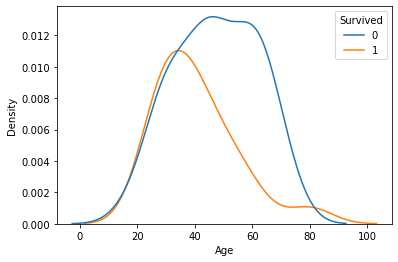

In [214]:
# It does not look like there is any meaningful portion of the graph that
# would make us predict a man survives, even though we technically could
# for high outlier values.
sns.kdeplot(data = df_men_age, x="Age", hue="Survived", multiple="layer")

In [215]:
# Unfortunately, I will give up on predicting that any men with no family
# members or ticket group members will survive. This leaves men with 
# other people in their ticket group.

# Of these men, 2/11 first class passengers survive, 0/10 second class 
# passengers survive, and 6/8 third class passengers survive.
train_transformed[
    ((train_transformed["family_total_train"] == 0) |
     ((train_transformed["adult"] == 0) &
      (train_transformed["men_total"] >= 1) &
      (train_transformed["women_total"] == 0) &
      (train_transformed["girls_total"] == 0) &
      (train_transformed["boys_total"] == 0))) &
    (train_transformed["adult"] == 1) &
    (train_transformed["Sex"] == 0) &
    (train_transformed["ticket_total_train"] >= 1)][
    ["Survived", "Pclass"]].value_counts().sort_index()

Survived  Pclass
0         1          9
          2         10
          3          8
1         1          2
          3          6
dtype: int64

In [216]:
# # Unfortunately, I will give up on predicting that any men with no family
# # members or ticket group members will survive. This leaves men with 
# # other people in their ticket group.

# # Of these men, 2/11 first class passengers survive, 0/10 second class 
# # passengers survive, and 6/8 third class passengers survive.
# train_subset_3[
#     (train_subset_3["adult"] == 1) &
#     (train_subset_3["Sex"] == 0) &
#     (train_subset_3["ticket_total_train"] >= 1)][
#     ["Survived", "Pclass"]].value_counts().sort_index()

In [217]:
# 25 of these men were traveling in groups with other men.
train_transformed[
    ((train_transformed["family_total_train"] == 0) |
     ((train_transformed["adult"] == 0) &
      (train_transformed["men_total"] >= 1) &
      (train_transformed["women_total"] == 0) &
      (train_transformed["girls_total"] == 0) &
      (train_transformed["boys_total"] == 0))) &
    (train_transformed["adult"] == 1) &
    (train_transformed["Sex"] == 0) &
    (train_transformed["ticket_total_train"] >= 1) &
    (train_transformed["ticket_men_total"] >= 1)][
    ["Survived"]].value_counts().sort_index()

Survived
0           19
1            6
dtype: int64

In [218]:
# # 25 of these men were traveling in groups with other men.
# train_subset_3[
#     (train_subset_3["adult"] == 1) &
#     (train_subset_3["Sex"] == 0) &
#     (train_subset_3["ticket_total_train"] >= 1) &
#     (train_subset_3["ticket_men_total"] >= 1)][
#     ["Survived"]].value_counts().sort_index()

In [219]:
# Only one man was in a group where all other men survived.  This man lived.
train_transformed[
    ((train_transformed["family_total_train"] == 0) |
     ((train_transformed["adult"] == 0) &
      (train_transformed["men_total"] >= 1) &
      (train_transformed["women_total"] == 0) &
      (train_transformed["girls_total"] == 0) &
      (train_transformed["boys_total"] == 0))) &
    (train_transformed["adult"] == 1) &
    (train_transformed["Sex"] == 0) &
    (train_transformed["ticket_total_train"] >= 1) &
    (train_transformed["ticket_men_total"] >= 1) &
    (train_transformed["ticket_men_died"] == 0)][
    ["Survived"]].value_counts().sort_index()

Survived
1           1
dtype: int64

In [220]:
# # Only one man was in a group where all other men survived.  This man lived.
# train_subset_3[
#     (train_subset_3["adult"] == 1) &
#     (train_subset_3["Sex"] == 0) &
#     (train_subset_3["ticket_total_train"] >= 1) &
#     (train_subset_3["ticket_men_total"] >= 1) &
#     (train_subset_3["ticket_men_died"] == 0)][
#     ["Survived"]].value_counts().sort_index()

In [221]:
# Men in ticket groups where at least one man survived lived themselves 5/7
# times.
train_transformed[
    ((train_transformed["family_total_train"] == 0) |
     ((train_transformed["adult"] == 0) &
      (train_transformed["men_total"] >= 1) &
      (train_transformed["women_total"] == 0) &
      (train_transformed["girls_total"] == 0) &
      (train_transformed["boys_total"] == 0))) &
    (train_transformed["adult"] == 1) &
    (train_transformed["Sex"] == 0) &
    (train_transformed["ticket_total_train"] >= 1) &
    (train_transformed["ticket_men_total"] >= 1) &
    (train_transformed["ticket_men_survived"] >= 1)][
    ["Survived"]].value_counts().sort_index()

Survived
0           2
1           5
dtype: int64

In [222]:
# # Men in ticket groups where at least one man survived lived themselves 5/7
# # times.
# train_subset_3[
#     (train_subset_3["adult"] == 1) &
#     (train_subset_3["Sex"] == 0) &
#     (train_subset_3["ticket_total_train"] >= 1) &
#     (train_subset_3["ticket_men_total"] >= 1) &
#     (train_subset_3["ticket_men_survived"] >= 1)][
#     ["Survived"]].value_counts().sort_index()

In [223]:
#### Delete this cell?  Probably ####

# # Men in ticket groups where no other passengers died, and that had at 
# # least one boy, girl or woman survived 2/8 times.
# train_subset_3[
#     (train_subset_3["adult"] == 1) &
#     (train_subset_3["Sex"] == 0) &
#     (train_subset_3["ticket_total_train"] >= 1) &
#     (train_subset_3["ticket_girls_died"] == 0) &
#     (train_subset_3["ticket_boys_died"] == 0) &
#     (train_subset_3["ticket_women_died"] == 0) &
#     (train_subset_3["ticket_men_died"] == 0) &
#     ((train_subset_3["ticket_girls_total"] >= 1) |
#      (train_subset_3["ticket_boys_total"] >= 1) |
#      (train_subset_3["ticket_women_total"] >= 1))][
#     ["Survived", "Pclass"]].value_counts().sort_index()

In [224]:
# For this subset, we will only select men to live who are in groups where
# other men live.  This correctly selects 5/6 surviving men, and only 
# misclassifies 2 men to survive who die.

In [225]:
# Now, moving on to the women of subset 3.
# 1/41 first class women died
# 4/33 second class women died
# 22/54 third class women died.
# How can we predict which of these women will die?
train_transformed[
    ((train_transformed["family_total_train"] == 0) |
     ((train_transformed["adult"] == 0) &
      (train_transformed["men_total"] >= 1) &
      (train_transformed["women_total"] == 0) &
      (train_transformed["girls_total"] == 0) &
      (train_transformed["boys_total"] == 0))) &
    (train_transformed["adult"] == 1) &
    (train_transformed["Sex"] == 1)][
    ["Survived", "Pclass"]].value_counts().sort_index()

Survived  Pclass
0         1          1
          2          4
          3         22
1         1         40
          2         29
          3         32
dtype: int64

In [226]:
# # Now, moving on to the women of subset 3.
# # 1/41 first class women died
# # 4/33 second class women died
# # 22/54 third class women died.
# # How can we predict which of these women will die?
# train_subset_3[
#     (train_subset_3["adult"] == 1) &
#     (train_subset_3["Sex"] == 1)][
#     ["Survived", "Pclass"]].value_counts().sort_index()

In [227]:
# First, we will look at the subset of these women who had no other family 
# members in the train set.
# 1/12 first class women die
# 3/30 second class women die
# 22/53 third class women die.

# Interestingly, it seems as if the majority of first class women were 
# traveling with people in their ticket group, and the majority of second
# and third class women were travelling with no one in their ticket group.
# This can be seen by comparing the results of this cell and the cell above.
train_transformed[
    ((train_transformed["family_total_train"] == 0) |
     ((train_transformed["adult"] == 0) &
      (train_transformed["men_total"] >= 1) &
      (train_transformed["women_total"] == 0) &
      (train_transformed["girls_total"] == 0) &
      (train_transformed["boys_total"] == 0))) &
    (train_transformed["adult"] == 1) &
    (train_transformed["Sex"] == 1) &
    (train_transformed["ticket_total_train"] == 0)][
    ["Survived", "Pclass"]].value_counts().sort_index()

Survived  Pclass
0         1          1
          2          3
          3         22
1         1         11
          2         27
          3         31
dtype: int64

In [228]:
# # First, we will look at the subset of these women who had no other family 
# # members in the train set.
# # 1/12 first class women die
# # 3/30 second class women die
# # 22/53 third class women die.

# # Interestingly, it seems as if the majority of first class women were 
# # traveling with people in their ticket group, and the majority of second
# # and third class women were travelling with no one in their ticket group.
# # This can be seen by comparing the results of this cell and the cell above.
# train_subset_3[
#     (train_subset_3["adult"] == 1) &
#     (train_subset_3["Sex"] == 1) &
#     (train_subset_3["ticket_total_train"] == 0)][
#     ["Survived", "Pclass"]].value_counts().sort_index()

In [229]:
# The majority of the deaths come from Pclass 3.  Lets take a look at the
# age distributions of women in this pclass, and the effects on survival.
df_women_age = train_transformed[
    ((train_transformed["family_total_train"] == 0) |
     ((train_transformed["adult"] == 0) &
      (train_transformed["men_total"] >= 1) &
      (train_transformed["women_total"] == 0) &
      (train_transformed["girls_total"] == 0) &
      (train_transformed["boys_total"] == 0))) &
    (train_transformed["adult"] == 1) &
    (train_transformed["Sex"] == 1) &
    (train_transformed["ticket_total_train"] == 0) &
    (train_transformed["Pclass"] == 3)][
    ["Survived", "Age"]].copy()

In [230]:
# # The majority of the deaths come from Pclass 3.  Lets take a look at the
# # age distributions of women in this pclass, and the effects on survival.
# df_women_age = train_subset_3[
#     (train_subset_3["adult"] == 1) &
#     (train_subset_3["Sex"] == 1) &
#     (train_subset_3["ticket_total_train"] == 0) &
#     (train_subset_3["Pclass"] == 3)][
#     ["Survived", "Age"]].copy()

In [231]:
# 22/53 of these women died
df_women_age["Survived"].value_counts()

1    31
0    22
Name: Survived, dtype: int64

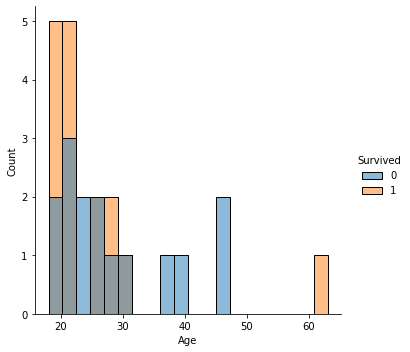

In [232]:
# Just eyeballing this graph, we could make a predictiong that women 
# in pclass 3 age 35 to 55 are more likely to die.  This is a pattern
# of adult survival we have already seen, where younger and older adults
# have a good chance to live, but middle aged adults are more likely to die.
# However, there are only 4 examples of death here, so I don't think its
# convincing enough to create a rule.
sns.displot(data=df_women_age, x="Age", hue="Survived", multiple="layer",
            bins=20)

In [233]:
# Selecting women traveling with no ticket group members who are pclass 3 
# and age 35-55 yields 4 dying women.  These four women are not related.
train_transformed[
    ((train_transformed["family_total_train"] == 0) |
     ((train_transformed["adult"] == 0) &
      (train_transformed["men_total"] >= 1) &
      (train_transformed["women_total"] == 0) &
      (train_transformed["girls_total"] == 0) &
      (train_transformed["boys_total"] == 0))) &
    (train_transformed["adult"] == 1) &
    (train_transformed["Sex"] == 1) &
    (train_transformed["ticket_total_train"] == 0) &
    (train_transformed["Pclass"] == 3) &
    (train_transformed["Age"] > 35) &
    (train_transformed["Age"] < 55)][
    ["Survived", "lname", "Age", "family_members"]]

,Survived,lname,Age,family_members
40,0,Ahlin,40.0,1
132,0,Robins,47.0,1
276,0,Lindblom,45.0,0
503,0,Laitinen,37.0,0


In [234]:
# # Selecting women traveling with no ticket group members who are pclass 3 
# # and age 35-55 yields 4 dying women.  These four women are not related.
# train_subset_3[
#     (train_subset_3["adult"] == 1) &
#     (train_subset_3["Sex"] == 1) &
#     (train_subset_3["ticket_total_train"] == 0) &
#     (train_subset_3["Pclass"] == 3) &
#     (train_subset_3["Age"] > 35) &
#     (train_subset_3["Age"] < 55)][
#     ["Survived", "lname", "Age", "family_members"]]

In [235]:
# Checking the women age 35 and younger, we see the majority live.
train_transformed[
    ((train_transformed["family_total_train"] == 0) |
     ((train_transformed["adult"] == 0) &
      (train_transformed["men_total"] >= 1) &
      (train_transformed["women_total"] == 0) &
      (train_transformed["girls_total"] == 0) &
      (train_transformed["boys_total"] == 0))) &
    (train_transformed["adult"] == 1) &
    (train_transformed["Sex"] == 1) &
    (train_transformed["ticket_total_train"] == 0) &
    (train_transformed["Pclass"] == 3) &
    (train_transformed["Age"] <= 35)][
    ["Survived"]].value_counts()

Survived
1           15
0           11
dtype: int64

In [236]:
# # Checking the women under 35, we see the majority live.
# train_subset_3[
#     (train_subset_3["adult"] == 1) &
#     (train_subset_3["Sex"] == 1) &
#     (train_subset_3["ticket_total_train"] == 0) &
#     (train_subset_3["Pclass"] == 3) &
#     (train_subset_3["Age"] < 35)][
#     ["Survived"]].value_counts()

In [237]:
# Above 55, there is only one single woman, and she lives as well.
# While we could just predict all women over 35 die, I am not going to make
# a rule predicting any of these women die because I do not have enough 
# data points.
train_transformed[
    ((train_transformed["family_total_train"] == 0) |
     ((train_transformed["adult"] == 0) &
      (train_transformed["men_total"] >= 1) &
      (train_transformed["women_total"] == 0) &
      (train_transformed["girls_total"] == 0) &
      (train_transformed["boys_total"] == 0))) &
    (train_transformed["adult"] == 1) &
    (train_transformed["Sex"] == 1) &
    (train_transformed["ticket_total_train"] == 0) &
    (train_transformed["Pclass"] == 3) &
    (train_transformed["Age"] > 55)][
    ["Survived"]].value_counts()

Survived
1           1
dtype: int64

In [238]:
# # Above 55, there is only one single woman, and she lives as well.
# # While we could just predict all women over 35 die, 
# train_subset_3[
#     (train_subset_3["adult"] == 1) &
#     (train_subset_3["Sex"] == 1) &
#     (train_subset_3["ticket_total_train"] == 0) &
#     (train_subset_3["Pclass"] == 3) &
#     (train_subset_3["Age"] > 55)][
#     ["Survived"]].value_counts()

In [239]:
# Now looking at women who had other passengers in their ticket group
# 29/29 of the first class women survived
# 2/4 second class women survived
# The lone third class woman also survived.
train_transformed[
    ((train_transformed["family_total_train"] == 0) |
     ((train_transformed["adult"] == 0) &
      (train_transformed["men_total"] >= 1) &
      (train_transformed["women_total"] == 0) &
      (train_transformed["girls_total"] == 0) &
      (train_transformed["boys_total"] == 0))) &
    (train_transformed["adult"] == 1) &
    (train_transformed["Sex"] == 1) &
    (train_transformed["ticket_total_train"] >= 1)][
    ["Survived", "Pclass"]].value_counts()

Survived  Pclass
1         1         29
          2          2
0         2          1
1         3          1
dtype: int64

In [240]:
# # Now looking at women who had other passengers in their ticket group
# # 29/29 of the first class women survived
# # 2/4 second class women survived
# # The lone third class woman also survived.
# train_subset_3[
#     (train_subset_3["adult"] == 1) &
#     (train_subset_3["Sex"] == 1) &
#     (train_subset_3["ticket_total_train"] >= 1)][
#     ["Survived", "Pclass"]].value_counts().sort_index()

In [241]:
# It looks like we can forget about first class women dying altogether.
# Lets look at the set of women who were traveling with at least one
# child in their ticket group.  There are three of these women, two of whom
# survive.
train_transformed[
    ((train_transformed["family_total_train"] == 0) |
     ((train_transformed["adult"] == 0) &
      (train_transformed["men_total"] >= 1) &
      (train_transformed["women_total"] == 0) &
      (train_transformed["girls_total"] == 0) &
      (train_transformed["boys_total"] == 0))) &
    (train_transformed["adult"] == 1) &
    (train_transformed["Sex"] == 1) &
    (train_transformed["ticket_total_train"] >= 1) &
    (train_transformed["Pclass"] != 1) &
    ((train_transformed["ticket_boys_total"] >= 1) |
    (train_transformed["ticket_girls_total"] >= 1))][
    ["Survived", "Pclass"]].value_counts().sort_index()

Survived  Pclass
0         2         1
1         2         1
          3         1
dtype: int64

In [242]:
# # It looks like we can forget about first class women dying altogether.
# # Lets look at the set of women who were traveling with at least one
# # child in their ticket group.  There are three of these women, two of whom
# # survive.
# train_subset_3[
#     (train_subset_3["adult"] == 1) &
#     (train_subset_3["Sex"] == 1) &
#     (train_subset_3["ticket_total_train"] >= 1) &
#     (train_subset_3["Pclass"] != 1) &
#     ((train_subset_3["ticket_boys_total"] >= 1) |
#      (train_subset_3["ticket_girls_total"] >= 1))][
#     ["Survived", "Pclass"]].value_counts().sort_index()

In [243]:
# From the above subset, if we select a woman who was traveling with a boy
# or girl that died, we correctly select the one dying woman out of the 
# entire set of 33 women.  This will definitely qualify as a rule.
train_transformed[
    ((train_transformed["family_total_train"] == 0) |
     ((train_transformed["adult"] == 0) &
      (train_transformed["men_total"] >= 1) &
      (train_transformed["women_total"] == 0) &
      (train_transformed["girls_total"] == 0) &
      (train_transformed["boys_total"] == 0))) &
    (train_transformed["adult"] == 1) &
    (train_transformed["Sex"] == 1) &
    (train_transformed["ticket_total_train"] >= 1) &
    (train_transformed["Pclass"] != 1) &
    ((train_transformed["ticket_boys_total"] >= 1) |
     (train_transformed["ticket_girls_total"] >= 1)) &
    ((train_transformed["ticket_boys_died"] >= 1) |
     (train_transformed["ticket_girls_died"] >= 1))][
    ["Survived", "Pclass"]].value_counts().sort_index()

Survived  Pclass
0         2         1
dtype: int64

In [244]:
# # From the above subset, if we select a woman who was traveling with a boy
# # or girl that died, we correctly select the one dying woman out of the 
# # entire set of 33 women.  This will definitely qualify as a rule.
# train_subset_3[
#     (train_subset_3["adult"] == 1) &
#     (train_subset_3["Sex"] == 1) &
#     (train_subset_3["ticket_total_train"] >= 1) &
#     (train_subset_3["Pclass"] != 1) &
#     ((train_subset_3["ticket_boys_total"] >= 1) |
#      (train_subset_3["ticket_girls_total"] >= 1)) &
#     ((train_subset_3["ticket_boys_died"] >= 1) |
#      (train_subset_3["ticket_girls_died"] >= 1))][
#     ["Survived", "Pclass"]].value_counts().sort_index()

In [245]:
# Moving on to the boys of subset 3: 8/18 boys survive in total.
# 3/4 pclass 1 boys survive
# 2/4 pclass 2 boys survive
# 3/10 pclass 3 boys survive
train_transformed[
    ((train_transformed["family_total_train"] == 0) |
     ((train_transformed["adult"] == 0) &
      (train_transformed["men_total"] >= 1) &
      (train_transformed["women_total"] == 0) &
      (train_transformed["girls_total"] == 0) &
      (train_transformed["boys_total"] == 0))) &
    (train_transformed["adult"] == 0) &
    (train_transformed["Sex"] == 0)][
    ["Survived", "Pclass"]].value_counts().sort_index()

Survived  Pclass
0         1         1
          2         2
          3         7
1         1         3
          2         2
          3         3
dtype: int64

In [246]:
# # Moving on to the boys of subset 3: 8/18 boys survive in total.
# # 3/4 pclass 1 boys survive
# # 2/4 pclass 2 boys survive
# # 3/10 pclass 3 boys survive
# train_subset_3[
#     (train_subset_3["adult"] == 0) &
#     (train_subset_3["Sex"] == 0)][
#     ["Survived", "Pclass"]].value_counts().sort_index()

In [247]:
# For the boys traveling with no one in their ticket group, 4/10 boys 
# survive.
# 2/3 pclass one boys survive, and 2/7 pclass 3 boys.
train_transformed[
    ((train_transformed["family_total_train"] == 0) |
     ((train_transformed["adult"] == 0) &
      (train_transformed["men_total"] >= 1) &
      (train_transformed["women_total"] == 0) &
      (train_transformed["girls_total"] == 0) &
      (train_transformed["boys_total"] == 0))) &
    (train_transformed["adult"] == 0) &
    (train_transformed["Sex"] == 0) &
    (train_transformed["ticket_total_train"] == 0)][
    ["Survived", "Pclass"]].value_counts().sort_index()

Survived  Pclass
0         1         1
          3         5
1         1         2
          3         2
dtype: int64

In [248]:
# # For the boys traveling with no one in their ticket group, 4/10 boys 
# # survive.
# # 2/3 pclass one boys survive, and 2/7 pclass 3 boys.
# train_subset_3[
#     (train_subset_3["adult"] == 0) &
#     (train_subset_3["Sex"] == 0) &
#     (train_subset_3["ticket_total_train"] == 0)][
#     ["Survived", "Pclass"]].value_counts().sort_index()

In [249]:
# creating a df to graph
df_boys_age = train_transformed[
    ((train_transformed["family_total_train"] == 0) |
     ((train_transformed["adult"] == 0) &
      (train_transformed["men_total"] >= 1) &
      (train_transformed["women_total"] == 0) &
      (train_transformed["girls_total"] == 0) &
      (train_transformed["boys_total"] == 0))) &
    (train_transformed["adult"] == 0) &
    (train_transformed["Sex"] == 0) &
    (train_transformed["ticket_total_train"] == 0)][
    ["Survived", "Age"]].copy()

In [250]:
# # creating a df to graph
# df_boys_age = train_subset_3[
#     (train_subset_3["adult"] == 0) &
#     (train_subset_3["Sex"] == 0) &
#     (train_subset_3["ticket_total_train"] == 0)][
#     ["Survived", "Age"]].copy()

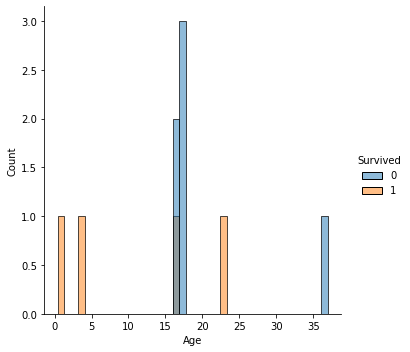

In [251]:
# The surviving boys have a lower average age, but it would be a stretch 
# to make any predictions based off this data alone.
sns.displot(data=df_boys_age, x="Age", hue="Survived")

In [252]:
# However, throughout the whole train dataset, young boys have a higher 
# probability of surviving than dying.  We will predict all boys from 
# subset 3 with no ticket group members who are 6 or under will
# survive.
train_transformed[
    (train_transformed["Age"] <= 6) &
    (train_transformed["Sex"] == 0)
][["Survived"]].value_counts().sort_index()

Survived
0            8
1           16
dtype: int64

In [253]:
# We will also predict all boys age 15 or under who are not in pclass 3 
# survive.
train_transformed[
    (train_transformed["Age"] <= 15) &
    (train_transformed["Sex"] == 0)
][["Survived", "Pclass"]].value_counts().sort_index()

Survived  Pclass
0         3         19
1         1          3
          2          9
          3          9
dtype: int64

In [254]:
# Here is the actual rule written out for these boys with no ticket group 
# members.  We would correctly select 2/4 possible survivors in the 
# training set without selecting any boys who die.
train_transformed[
    ((train_transformed["family_total_train"] == 0) |
     ((train_transformed["adult"] == 0) &
      (train_transformed["men_total"] >= 1) &
      (train_transformed["women_total"] == 0) &
      (train_transformed["girls_total"] == 0) &
      (train_transformed["boys_total"] == 0))) &
    (train_transformed["adult"] == 0) &
    (train_transformed["Sex"] == 0) &
    (train_transformed["ticket_total_train"] == 0) &
    ((train_transformed["Age"] <= 6) |
     ((train_transformed["Age"] <= 15) &
      (train_transformed["Pclass"] != 3)))][
    ["Survived", "Pclass"]].value_counts().sort_index()

Survived  Pclass
1         1         1
          3         1
dtype: int64

In [255]:
# For boys who share a ticket group with other passengers in train:
# The only pclass 1 boy survives
# 2/4 pclass two boys survive
# 1/3 pclass three boys survive
train_transformed[
    ((train_transformed["family_total_train"] == 0) |
     ((train_transformed["adult"] == 0) &
      (train_transformed["men_total"] >= 1) &
      (train_transformed["women_total"] == 0) &
      (train_transformed["girls_total"] == 0) &
      (train_transformed["boys_total"] == 0))) &
    (train_transformed["adult"] == 0) &
    (train_transformed["Sex"] == 0) &
    (train_transformed["ticket_total_train"] >= 1)][
    ["Survived", "Pclass"]].value_counts().sort_index()

Survived  Pclass
0         2         2
          3         2
1         1         1
          2         2
          3         1
dtype: int64

In [256]:
# # For boys who share a ticket group with other passengers in train:
# # The only pclass 1 boy survives
# # 2/4 pclass two boys survive
# # 1/3 pclass three boys survive
# train_subset_3[
#     (train_subset_3["adult"] == 0) &
#     (train_subset_3["Sex"] == 0) &
#     (train_subset_3["ticket_total_train"] >= 1)][
#     ["Survived", "Pclass"]].value_counts().sort_index()

In [257]:
# Here is the subset of boys traveling with at least one boy, girl or 
# woman in their ticket group
train_transformed[
    ((train_transformed["family_total_train"] == 0) |
     ((train_transformed["adult"] == 0) &
      (train_transformed["men_total"] >= 1) &
      (train_transformed["women_total"] == 0) &
      (train_transformed["girls_total"] == 0) &
      (train_transformed["boys_total"] == 0))) &
    (train_transformed["adult"] == 0) &
    (train_transformed["Sex"] == 0) &
    (train_transformed["ticket_total_train"] >= 1) &
    ((train_transformed["ticket_boys_total"] >= 1) |
     (train_transformed["ticket_girls_total"] >= 1) |
     (train_transformed["ticket_women_total"] >= 1))][
    ["Survived", "Pclass"]].value_counts().sort_index()

Survived  Pclass
0         2         1
1         1         1
dtype: int64

In [258]:
# # Here is the subset of boys traveling with at least one boy, girl or 
# # woman in their ticket group
# train_subset_3[
#     (train_subset_3["adult"] == 0) &
#     (train_subset_3["Sex"] == 0) &
#     (train_subset_3["ticket_total_train"] >= 1) &
#     ((train_subset_3["ticket_boys_total"] >= 1) |
#      (train_subset_3["ticket_girls_total"] >= 1) |
#      (train_subset_3["ticket_women_total"] >= 1))][
#     ["Survived", "Pclass"]].value_counts().sort_index()

In [259]:
# For the above subset, if no other boys, girls or women in the ticket 
# group die, we can correctly select 1 boy who survives from the subset.
train_transformed[
    ((train_transformed["family_total_train"] == 0) |
     ((train_transformed["adult"] == 0) &
      (train_transformed["men_total"] >= 1) &
      (train_transformed["women_total"] == 0) &
      (train_transformed["girls_total"] == 0) &
      (train_transformed["boys_total"] == 0))) &
    (train_transformed["adult"] == 0) &
    (train_transformed["Sex"] == 0) &
    (train_transformed["ticket_total_train"] >= 1) &
    ((train_transformed["ticket_boys_total"] >= 1) |
     (train_transformed["ticket_girls_total"] >= 1) |
     (train_transformed["ticket_women_total"] >= 1)) &
    (train_transformed["ticket_boys_died"] == 0) &
    (train_transformed["ticket_girls_died"] == 0) &
    (train_transformed["ticket_women_died"] == 0)][
    ["Survived", "Pclass"]].value_counts().sort_index()

Survived  Pclass
1         1         1
dtype: int64

In [260]:
# # For the above subset, if no other boys, girls or women in the ticket 
# # group die, we can correctly select 1 boy who survives from the subset.
# train_subset_3[
#     (train_subset_3["adult"] == 0) &
#     (train_subset_3["Sex"] == 0) &
#     (train_subset_3["ticket_total_train"] >= 1) &
#     ((train_subset_3["ticket_boys_total"] >= 1) |
#      (train_subset_3["ticket_girls_total"] >= 1) |
#      (train_subset_3["ticket_women_total"] >= 1)) &
#     (train_subset_3["ticket_boys_died"] == 0) &
#     (train_subset_3["ticket_girls_died"] == 0) &
#     (train_subset_3["ticket_women_died"] == 0)][
#     ["Survived", "Pclass"]].value_counts().sort_index()

In [261]:
# Finally, we move on to the girls from subset 3.
# All 12 girls from pclass 1 survive
# All 8 girls from pclass 2 survive
# 11/14 girls from pclass 3 survive
train_transformed[
    ((train_transformed["family_total_train"] == 0) |
     ((train_transformed["adult"] == 0) &
      (train_transformed["men_total"] >= 1) &
      (train_transformed["women_total"] == 0) &
      (train_transformed["girls_total"] == 0) &
      (train_transformed["boys_total"] == 0))) &
    (train_transformed["adult"] == 0) &
    (train_transformed["Sex"] == 1)][
    ["Survived", "Pclass"]].value_counts().sort_index()

Survived  Pclass
0         3          3
1         1         12
          2          8
          3         11
dtype: int64

In [262]:
# # Finally, we move on to the girls from subset 3.
# # All 12 girls from pclass 1 survive
# # All 8 girls from pclass 2 survive
# # 11/14 girls from pclass 3 survive
# train_subset_3[
#     (train_subset_3["adult"] == 0) &
#     (train_subset_3["Sex"] == 1)][
#     ["Survived", "Pclass"]].value_counts().sort_index()

In [263]:
# Here are the girls in this subset without any other passengers in their
# train ticket group.  4/4 girls from pclass 1 survive, 5/5 girls from 
# pclass 2 survive, and 8/9 girls from pclass 3 survive.  I don't think
# that it will be possible to predict that any of these girls will die 
# based on variables such as pclass, fare or age.
train_transformed[
    ((train_transformed["family_total_train"] == 0) |
     ((train_transformed["adult"] == 0) &
      (train_transformed["men_total"] >= 1) &
      (train_transformed["women_total"] == 0) &
      (train_transformed["girls_total"] == 0) &
      (train_transformed["boys_total"] == 0))) &
    (train_transformed["adult"] == 0) &
    (train_transformed["Sex"] == 1) &
    (train_transformed["ticket_total_train"] == 0)][
    ["Survived", "Pclass"]].value_counts().sort_index()

Survived  Pclass
0         3         1
1         1         4
          2         5
          3         8
dtype: int64

In [264]:
# # Here are the girls in this subset without any other passengers in their
# # train ticket group.  4/4 girls from pclass 1 survive, 5/5 girls from 
# # pclass 2 survive, and 8/9 girls from pclass 3 survive.  I don't think
# # that it will be possible to predict that any of these girls will die 
# # based on variables such as pclass, fare or age.
# train_subset_3[
#     (train_subset_3["adult"] == 0) &
#     (train_subset_3["Sex"] == 1) &
#     (train_subset_3["ticket_total_train"] == 0)][
#     ["Survived", "Pclass"]].value_counts().sort_index()

In [265]:
# Lets look at the girls of subset 3 who are traveling with other people
# in their ticket group.
# No first or second class girls die, but 2/5 third class girls die.
train_transformed[
    ((train_transformed["family_total_train"] == 0) |
     ((train_transformed["adult"] == 0) &
      (train_transformed["men_total"] >= 1) &
      (train_transformed["women_total"] == 0) &
      (train_transformed["girls_total"] == 0) &
      (train_transformed["boys_total"] == 0))) &
    (train_transformed["adult"] == 0) &
    (train_transformed["Sex"] == 1) &
    (train_transformed["ticket_total_train"] >= 1)][
    ["Survived", "Pclass"]].value_counts().sort_index()

Survived  Pclass
0         3         2
1         1         8
          2         3
          3         3
dtype: int64

In [266]:
# # Lets look at the girls of subset 3 who are traveling with other people
# # in their ticket group.
# # No first or second class girls die, but 2/5 third class girls die.
# train_subset_3[
#     (train_subset_3["adult"] == 0) &
#     (train_subset_3["Sex"] == 1) &
#     (train_subset_3["ticket_total_train"] >= 1)][
#     ["Survived", "Pclass"]].value_counts().sort_index()

In [267]:
# If we require that the girl is traveling with at least one boy, girl or 
# woman in the ticket group, and that no one in the ticket group survives, 
# we fail to select any of the train set girls in subset 3 with ticket
# group members in train who die.  However, I would be comfortable using 
# this as a rule to predict death on the test set.
train_transformed[
    ((train_transformed["family_total_train"] == 0) |
     ((train_transformed["adult"] == 0) &
      (train_transformed["men_total"] >= 1) &
      (train_transformed["women_total"] == 0) &
      (train_transformed["girls_total"] == 0) &
      (train_transformed["boys_total"] == 0))) &
    (train_transformed["adult"] == 0) &
    (train_transformed["Sex"] == 1) &
    (train_transformed["ticket_total_train"] >= 1) &
    ((train_transformed["ticket_girls_total"] >= 1) |
     (train_transformed["ticket_boys_total"] >= 1) |
     (train_transformed["ticket_women_total"] >= 1)) &
    (train_transformed["ticket_girls_survived"] == 0) &
    (train_transformed["ticket_boys_survived"] == 0) &
    (train_transformed["ticket_women_survived"] == 0) &
    (train_transformed["ticket_men_survived"] == 0)][
    ["Survived", "Pclass"]].value_counts().sort_index()

Series([], dtype: int64)

In [268]:
# # If we require that the girl is traveling with at least one boy, girl or 
# # woman in the ticket group, and that no one in the ticket group survives, 
# # we fail to select any of the train set girls in subset 3 with ticket
# # group members in train who die.  However, I would be comfortable using 
# # this as a rule to predict death on the test set.
# train_subset_3[
#     (train_subset_3["adult"] == 0) &
#     (train_subset_3["Sex"] == 1) &
#     (train_subset_3["ticket_total_train"] >= 1) &
#     ((train_subset_3["ticket_girls_total"] >= 1) |
#      (train_subset_3["ticket_boys_total"] >= 1) |
#      (train_subset_3["ticket_women_total"] >= 1)) &
#     (train_subset_3["ticket_girls_survived"] == 0) &
#     (train_subset_3["ticket_boys_survived"] == 0) &
#     (train_subset_3["ticket_women_survived"] == 0) &
#     (train_subset_3["ticket_men_survived"] == 0)][
#     ["Survived", "Pclass"]].value_counts().sort_index()

In [269]:
# Now, before we get to the stage of applying our rule based model to the
# test set, we have a couple of tasks left to accomplish.
# 1) Decide what to do with the subsets which we have decided to "assign 
#    for further use from an algorithm."  I have decided to scrap many of 
#    these small sets that have relatively equal members surviving and
#    dying, because I want to do as little guessing as possible that is
#    not backed up by some logical survival ideas.  
# 2) See how the model performs on the training set as a whole.

In [270]:
# First, we will make predictions on the train set and see how our model 
# does on the whole.  I would not be suprised if the train model ended up
# being significantly overfit, so it is possible that good train 
# accuracy will not translate to good test accuracy.

In [271]:
# I will begin by creating a pred column on the train set, and 
# populate it to start according to the gender model.
train_transformed["pred"] = 0
train_transformed.loc[(train_transformed["Sex"] == 1), ["pred"]] = 1

In [272]:
# I will now update the column based on my rules, and then contrast the pred
# values with the survived column to see my accuracy.  First, I will update
# pred for passengers in subset 1.

# Updating pred for women with only girls
train_transformed.loc[
    (train_transformed["Parch"] >= 1) &
    (train_transformed["family_total_train"] >= 1) &
    (train_transformed["Sex"] == 1) &
    (train_transformed["adult"] == 1) &
    (train_transformed["girls_total"] >= 1) &
    (train_transformed["boys_total"] == 0) &
    (train_transformed["girls_died"] >= 1), ["pred"]] = 0

# Updating for women with only boys
train_transformed.loc[    
    (train_transformed["Parch"] >= 1) &
    (train_transformed["family_total_train"] >= 1) &
    (train_transformed["Sex"] == 1) &
    (train_transformed["adult"] == 1) &
    (train_transformed["girls_total"] == 0) &
    (train_transformed["boys_total"] >= 1) &
    (train_transformed["boys_died"] >= 1) &
    (train_transformed["Pclass"] == 3), ["pred"]] = 0

# Updating for women with boys and girls
train_transformed.loc[
    (train_transformed["Parch"] >= 1) &
    (train_transformed["family_total_train"] >= 1) &
    (train_transformed["Sex"] == 1) &
    (train_transformed["adult"] == 1) &
    (train_transformed["girls_total"] >= 1) &
    (train_transformed["boys_total"] >= 1) &
    (train_transformed["girls_died"] >= 1), ["pred"]] = 0

# Updating for girls who have only women in train
train_transformed.loc[
    (train_transformed["Parch"] >= 1) &
    (train_transformed["Sex"] == 1) &
    (train_transformed["adult"] == 0) &
    (train_transformed["women_total"] >= 1) &
    (train_transformed["boys_total"] == 0) &
    (train_transformed["girls_total"] == 0) &
    (train_transformed["women_survived"] == 0), ["pred"]] = 0

# Updating for girls who have women and girls in train
train_transformed.loc[
    (train_transformed["Parch"] >= 1) &
    (train_transformed["Sex"] == 1) &
    (train_transformed["adult"] == 0) &
    (train_transformed["women_total"] >= 1) &
    (train_transformed["girls_total"] >= 1) &
    (train_transformed["boys_total"] == 0) &
    (train_transformed["girls_died"] == \
     train_transformed["girls_total"]) &
    (train_transformed["women_died"] == \
     train_transformed["women_total"]), ["pred"]] = 0

# Updating for girls who have women and boys in train
train_transformed.loc[
    (train_transformed["Parch"] >= 1) &
    (train_transformed["Sex"] == 1) &
    (train_transformed["adult"] == 0) &
    (train_transformed["women_total"] >= 1) &
    (train_transformed["girls_total"] == 0) &
    (train_transformed["boys_total"] >= 1) &
    (train_transformed["women_survived"] == 0) &
    (train_transformed["boys_survived"] == 0), ["pred"]] = 0

# Updating for girls who have women, boys and girls in train
train_transformed.loc[
    (train_transformed["Parch"] >= 1) &
    (train_transformed["Sex"] == 1) &
    (train_transformed["adult"] == 0) &
    (train_transformed["women_total"] >= 1) &
    (train_transformed["girls_total"] >= 1) &
    (train_transformed["boys_total"] >= 1) &
    (train_transformed["girls_died"] >= 1) &
    (train_transformed["boys_survived"] == 0) &
    (train_transformed["women_survived"] == 0), ["pred"]] = 0

# Updating for boys with only women in train
train_transformed.loc[
    (train_transformed["Parch"] >= 1) &
    (train_transformed["Sex"] == 0) &
    (train_transformed["adult"] == 0) &
    (train_transformed["women_total"] >= 1) &
    (train_transformed["boys_total"] == 0) &
    (train_transformed["girls_total"] == 0) &
    (train_transformed["women_survived"] >= 1) &
    (train_transformed["Pclass"] != 3), ["pred"]] = 1

# Updating for boys with women and boys in train
train_transformed.loc[
    (train_transformed["Parch"] >= 1) &
    (train_transformed["Sex"] == 0) &
    (train_transformed["adult"] == 0) &
    (train_transformed["women_total"] >= 1) &
    (train_transformed["boys_total"] >= 1) &
    (train_transformed["girls_total"] == 0) &
    (((train_transformed["women_survived"] >= 1) &
      (train_transformed["boys_survived"] >= 1)) |
     ((train_transformed["women_survived"] >= 1) &
      (train_transformed["boys_survived"] == 0) &
      (train_transformed["Pclass"] != 3))), ["pred"]] = 1

# Updating for boys with women and girls in train
train_transformed.loc[
    (train_transformed["Parch"] >= 1) &
    (train_transformed["Sex"] == 0) &
    (train_transformed["adult"] == 0) &
    (train_transformed["women_total"] >= 1) &
    (train_transformed["boys_total"] == 0) &
    (train_transformed["girls_total"] >= 1) &
    (train_transformed["girls_died"] == 0) &
    (train_transformed["women_survived"] >= 1), ["pred"]] = 1

# Updating for boys with women, boys and girls in train
train_transformed.loc[
    (train_transformed["Parch"] >= 1) &
    (train_transformed["Sex"] == 0) &
    (train_transformed["adult"] == 0) &
    (train_transformed["women_total"] >= 1) &
    (train_transformed["boys_total"] >= 1) &
    (train_transformed["girls_total"] >= 1) &
    (train_transformed["girls_died"] == 0) &
    (train_transformed["women_survived"] >= 1), ["pred"]] = 1



# Moving on to subset 2

# Updating for men with men and women in train
train_transformed.loc[
    (train_transformed["adult"] == 1) &
    (train_transformed["family_total_train"] >= 1) &
    (train_transformed["boys_total"] == 0) &
    (train_transformed["girls_total"] == 0) &
    (train_transformed["Sex"] == 0) &
    (train_transformed["men_total"] >= 1) &
    (train_transformed["women_total"] >= 1) &
    (train_transformed["women_died"] == 0) &
    (train_transformed["men_died"] == 0), ["pred"]] = 1

# Updating for men with only men in train
train_transformed.loc[
    (train_transformed["adult"] == 1) &
    (train_transformed["family_total_train"] >= 1) &
    (train_transformed["boys_total"] == 0) &
    (train_transformed["girls_total"] == 0) &
    (train_transformed["Sex"] == 0) &
    (train_transformed["men_total"] >= 1) &
    (train_transformed["women_total"] == 0) &
    (train_transformed["men_died"] == 0) &
    (train_transformed["Pclass"] == 1), ["pred"]] = 1

# Updating for women with men and women in train
train_transformed.loc[
    (train_transformed["adult"] == 1) &
    (train_transformed["family_total_train"] >= 1) &
    (train_transformed["boys_total"] == 0) &
    (train_transformed["girls_total"] == 0) &
    (train_transformed["Sex"] == 1) &
    (train_transformed["men_total"] >= 1) &
    (train_transformed["women_total"] >= 1) &
    (train_transformed["women_survived"] == 0) &
    (train_transformed["Pclass"] == 3), ["pred"]] = 0

# Updating for women traveling with only women in train
train_transformed.loc[
    (train_transformed["adult"] == 1) &
    (train_transformed["family_total_train"] >= 1) &
    (train_transformed["boys_total"] == 0) &
    (train_transformed["girls_total"] == 0) &
    (train_transformed["Sex"] == 1) &
    (train_transformed["men_total"] == 0) &
    (train_transformed["women_total"] >= 1) &
    (train_transformed["women_survived"] ==0) &
    (train_transformed["Pclass"] == 3), ["pred"]] = 0

# Updating for boys traveling with boys and girls in train
train_transformed.loc[
    (train_transformed["adult"] == 0) &
    (train_transformed["family_total_train"] >= 1) &
    (train_transformed["Sex"] == 0) &
    (train_transformed["women_total"] == 0) &
    (train_transformed["boys_total"] >= 1) &
    (train_transformed["girls_total"] >= 1) &
    (train_transformed["girls_died"] == 0), ["pred"]] = 1

# Updating for boys traveling with only boys in train
train_transformed.loc[
    (train_transformed["adult"] == 0) &
    (train_transformed["family_total_train"] >= 1) &
    (train_transformed["Sex"] == 0) &
    (train_transformed["women_total"] == 0) &
    (train_transformed["boys_total"] >= 1) &
    (train_transformed["girls_total"] == 0) &
    (train_transformed["boys_survived"] >= 1), ["pred"]] = 1

# Updating for boys traveling with only girls in train
train_transformed.loc[
    (train_transformed["adult"] == 0) &
    (train_transformed["family_total_train"] >= 1) &
    (train_transformed["Sex"] == 0) &
    (train_transformed["women_total"] == 0) &
    (train_transformed["boys_total"] == 0) &
    (train_transformed["girls_total"] >= 1) &
    (train_transformed["girls_died"] == 0), ["pred"]] = 1

# Updating for girls traveling with boys and girls in train
train_transformed.loc[
    (train_transformed["adult"] == 0) &
    (train_transformed["family_total_train"] >= 1) &
    (train_transformed["Sex"] == 1) &
    (train_transformed["women_total"] == 0) &
    (train_transformed["boys_total"] >= 1) &
    (train_transformed["girls_total"] >= 1) &
    (train_transformed["girls_survived"] == 0), ["pred"]] = 0

# Updating for girls traveling with girls in train 
train_transformed.loc[
    (train_transformed["adult"] == 0) &
    (train_transformed["family_total_train"] >= 1) &
    (train_transformed["Sex"] == 1) &
    (train_transformed["women_total"] == 0) &
    (train_transformed["boys_total"] == 0) &
    (train_transformed["girls_total"] >= 1) &
    (train_transformed["girls_survived"] == 0), ["pred"]] = 0

# Updating for girls traveling with boys in train
train_transformed.loc[
    (train_transformed["adult"] == 0) &
    (train_transformed["family_total_train"] >= 1) &
    (train_transformed["Sex"] == 1) &
    (train_transformed["women_total"] == 0) &
    (train_transformed["boys_total"] >= 1) &
    (train_transformed["girls_total"] == 0) &
    (train_transformed["boys_survived"] == 0) &
    (train_transformed["Pclass"] == 3), ["pred"]] = 0



# Now, we update the results on subset 3.

# Updating for men traveling with other passengers.  They will live when 
# at least one man survives.
train_transformed.loc[
    ((train_transformed["family_total_train"] == 0) |
     ((train_transformed["adult"] == 0) &
      (train_transformed["men_total"] >= 1) &
      (train_transformed["women_total"] == 0) &
      (train_transformed["girls_total"] == 0) &
      (train_transformed["boys_total"] == 0))) &
    (train_transformed["adult"] == 1) &
    (train_transformed["Sex"] == 0) &
    (train_transformed["ticket_total_train"] >= 1) &
    (train_transformed["ticket_men_total"] >= 1) &
    (train_transformed["ticket_men_survived"] >= 1), ["pred"]] = 1

# Updating for women traveling with children in their ticket group
train_transformed.loc[
    ((train_transformed["family_total_train"] == 0) |
     ((train_transformed["adult"] == 0) &
      (train_transformed["men_total"] >= 1) &
      (train_transformed["women_total"] == 0) &
      (train_transformed["girls_total"] == 0) &
      (train_transformed["boys_total"] == 0))) &
    (train_transformed["adult"] == 1) &
    (train_transformed["Sex"] == 1) &
    (train_transformed["ticket_total_train"] >= 1) &
    (train_transformed["Pclass"] != 1) &
    ((train_transformed["ticket_boys_total"] >= 1) |
     (train_transformed["ticket_girls_total"] >= 1)) &
    ((train_transformed["ticket_boys_died"] >= 1) |
     (train_transformed["ticket_girls_died"] >= 1)), ["pred"]] = 0

# Updating for boys in who have no one in their ticket group in train
train_transformed.loc[
    ((train_transformed["family_total_train"] == 0) |
     ((train_transformed["adult"] == 0) &
      (train_transformed["men_total"] >= 1) &
      (train_transformed["women_total"] == 0) &
      (train_transformed["girls_total"] == 0) &
      (train_transformed["boys_total"] == 0))) &
    (train_transformed["adult"] == 0) &
    (train_transformed["Sex"] == 0) &
    (train_transformed["ticket_total_train"] == 0) &
    ((train_transformed["Age"] <= 6) |
     ((train_transformed["Age"] <= 15) &
      (train_transformed["Pclass"] != 3))), ["pred"]] = 1

# Updating for boys traveling with boys, girls or women in their ticket
# group
train_transformed.loc[
    ((train_transformed["family_total_train"] == 0) |
     ((train_transformed["adult"] == 0) &
      (train_transformed["men_total"] >= 1) &
      (train_transformed["women_total"] == 0) &
      (train_transformed["girls_total"] == 0) &
      (train_transformed["boys_total"] == 0))) &
    (train_transformed["adult"] == 0) &
    (train_transformed["Sex"] == 0) &
    (train_transformed["ticket_total_train"] >= 1) &
    ((train_transformed["ticket_boys_total"] >= 1) |
     (train_transformed["ticket_girls_total"] >= 1) |
     (train_transformed["ticket_women_total"] >= 1)) &
    (train_transformed["ticket_boys_died"] == 0) &
    (train_transformed["ticket_girls_died"] == 0) &
    (train_transformed["ticket_women_died"] == 0), ["pred"]] = 1

# Updating for girls traveling with at least one woman, boy or girl
# in their ticket group.
train_transformed.loc[
    ((train_transformed["family_total_train"] == 0) |
     ((train_transformed["adult"] == 0) &
      (train_transformed["men_total"] >= 1) &
      (train_transformed["women_total"] == 0) &
      (train_transformed["girls_total"] == 0) &
      (train_transformed["boys_total"] == 0))) &
    (train_transformed["adult"] == 0) &
    (train_transformed["Sex"] == 1) &
    (train_transformed["ticket_total_train"] >= 1) &
    ((train_transformed["ticket_girls_total"] >= 1) |
     (train_transformed["ticket_boys_total"] >= 1) |
     (train_transformed["ticket_women_total"] >= 1)) &
    (train_transformed["ticket_girls_survived"] == 0) &
    (train_transformed["ticket_boys_survived"] == 0) &
    (train_transformed["ticket_women_survived"] == 0) &
    (train_transformed["ticket_men_survived"] == 0), ["pred"]] = 0

In [273]:
train_transformed[["pred", "Survived"]].value_counts()

pred  Survived
0     0           500
1     1           256
0     1            86
1     0            49
dtype: int64

In [274]:
# Now, I will update the test set according to the rules I created

# Creating the pred column in test set, initializing all values to zero
x_test_transformed_df["pred"] = 0

# Predicting all women will survive.
x_test_transformed_df.loc[
    (x_test_transformed_df["Sex"] == 1), ["pred"]] = 1

In [275]:
# I will now update the column based on my rules

# Updating pred for women with only girls
x_test_transformed_df.loc[
    (x_test_transformed_df["Parch"] >= 1) &
    (x_test_transformed_df["family_total_train"] >= 1) &
    (x_test_transformed_df["Sex"] == 1) &
    (x_test_transformed_df["adult"] == 1) &
    (x_test_transformed_df["girls_total"] >= 1) &
    (x_test_transformed_df["boys_total"] == 0) &
    (x_test_transformed_df["girls_died"] >= 1), ["pred"]] = 0

# Updating for women with only boys
x_test_transformed_df.loc[    
    (x_test_transformed_df["Parch"] >= 1) &
    (x_test_transformed_df["family_total_train"] >= 1) &
    (x_test_transformed_df["Sex"] == 1) &
    (x_test_transformed_df["adult"] == 1) &
    (x_test_transformed_df["girls_total"] == 0) &
    (x_test_transformed_df["boys_total"] >= 1) &
    (x_test_transformed_df["boys_died"] >= 1) &
    (x_test_transformed_df["Pclass"] == 3), ["pred"]] = 0

# Updating for women with boys and girls
x_test_transformed_df.loc[
    (x_test_transformed_df["Parch"] >= 1) &
    (x_test_transformed_df["family_total_train"] >= 1) &
    (x_test_transformed_df["Sex"] == 1) &
    (x_test_transformed_df["adult"] == 1) &
    (x_test_transformed_df["girls_total"] >= 1) &
    (x_test_transformed_df["boys_total"] >= 1) &
    (x_test_transformed_df["girls_died"] >= 1), ["pred"]] = 0

# Updating for girls who have only women in train
x_test_transformed_df.loc[
    (x_test_transformed_df["Parch"] >= 1) &
    (x_test_transformed_df["Sex"] == 1) &
    (x_test_transformed_df["adult"] == 0) &
    (x_test_transformed_df["women_total"] >= 1) &
    (x_test_transformed_df["boys_total"] == 0) &
    (x_test_transformed_df["girls_total"] == 0) &
    (x_test_transformed_df["women_survived"] == 0), ["pred"]] = 0

# Updating for girls who have women and girls in train
x_test_transformed_df.loc[
    (x_test_transformed_df["Parch"] >= 1) &
    (x_test_transformed_df["Sex"] == 1) &
    (x_test_transformed_df["adult"] == 0) &
    (x_test_transformed_df["women_total"] >= 1) &
    (x_test_transformed_df["girls_total"] >= 1) &
    (x_test_transformed_df["boys_total"] == 0) &
    (x_test_transformed_df["girls_died"] == \
     x_test_transformed_df["girls_total"]) &
    (x_test_transformed_df["women_died"] == \
     x_test_transformed_df["women_total"]), ["pred"]] = 0

# Updating for girls who have women and boys in train
x_test_transformed_df.loc[
    (x_test_transformed_df["Parch"] >= 1) &
    (x_test_transformed_df["Sex"] == 1) &
    (x_test_transformed_df["adult"] == 0) &
    (x_test_transformed_df["women_total"] >= 1) &
    (x_test_transformed_df["girls_total"] == 0) &
    (x_test_transformed_df["boys_total"] >= 1) &
    (x_test_transformed_df["women_survived"] == 0) &
    (x_test_transformed_df["boys_survived"] == 0), ["pred"]] = 0

# Updating for girls who have women, boys and girls in train
x_test_transformed_df.loc[
    (x_test_transformed_df["Parch"] >= 1) &
    (x_test_transformed_df["Sex"] == 1) &
    (x_test_transformed_df["adult"] == 0) &
    (x_test_transformed_df["women_total"] >= 1) &
    (x_test_transformed_df["girls_total"] >= 1) &
    (x_test_transformed_df["boys_total"] >= 1) &
    (x_test_transformed_df["girls_died"] >= 1) &
    (x_test_transformed_df["boys_survived"] == 0) &
    (x_test_transformed_df["women_survived"] == 0), ["pred"]] = 0

# Updating for boys with only women in train
x_test_transformed_df.loc[
    (x_test_transformed_df["Parch"] >= 1) &
    (x_test_transformed_df["Sex"] == 0) &
    (x_test_transformed_df["adult"] == 0) &
    (x_test_transformed_df["women_total"] >= 1) &
    (x_test_transformed_df["boys_total"] == 0) &
    (x_test_transformed_df["girls_total"] == 0) &
    (x_test_transformed_df["women_survived"] >= 1) &
    (x_test_transformed_df["Pclass"] != 3), ["pred"]] = 1

# Updating for boys with women and boys in train
x_test_transformed_df.loc[
    (x_test_transformed_df["Parch"] >= 1) &
    (x_test_transformed_df["Sex"] == 0) &
    (x_test_transformed_df["adult"] == 0) &
    (x_test_transformed_df["women_total"] >= 1) &
    (x_test_transformed_df["boys_total"] >= 1) &
    (x_test_transformed_df["girls_total"] == 0) &
    (((x_test_transformed_df["women_survived"] >= 1) &
      (x_test_transformed_df["boys_survived"] >= 1)) |
     ((x_test_transformed_df["women_survived"] >= 1) &
      (x_test_transformed_df["boys_survived"] == 0) &
      (x_test_transformed_df["Pclass"] != 3))), ["pred"]] = 1

# Updating for boys with women and girls in train
x_test_transformed_df.loc[
    (x_test_transformed_df["Parch"] >= 1) &
    (x_test_transformed_df["Sex"] == 0) &
    (x_test_transformed_df["adult"] == 0) &
    (x_test_transformed_df["women_total"] >= 1) &
    (x_test_transformed_df["boys_total"] == 0) &
    (x_test_transformed_df["girls_total"] >= 1) &
    (x_test_transformed_df["girls_died"] == 0) &
    (x_test_transformed_df["women_survived"] >= 1), ["pred"]] = 1

# Updating for boys with women, boys and girls in train
x_test_transformed_df.loc[
    (x_test_transformed_df["Parch"] >= 1) &
    (x_test_transformed_df["Sex"] == 0) &
    (x_test_transformed_df["adult"] == 0) &
    (x_test_transformed_df["women_total"] >= 1) &
    (x_test_transformed_df["boys_total"] >= 1) &
    (x_test_transformed_df["girls_total"] >= 1) &
    (x_test_transformed_df["girls_died"] == 0) &
    (x_test_transformed_df["women_survived"] >= 1), ["pred"]] = 1



# Moving on to subset 2

# Updating for men with men and women in train
x_test_transformed_df.loc[
    (x_test_transformed_df["adult"] == 1) &
    (x_test_transformed_df["family_total_train"] >= 1) &
    (x_test_transformed_df["boys_total"] == 0) &
    (x_test_transformed_df["girls_total"] == 0) &
    (x_test_transformed_df["Sex"] == 0) &
    (x_test_transformed_df["men_total"] >= 1) &
    (x_test_transformed_df["women_total"] >= 1) &
    (x_test_transformed_df["women_died"] == 0) &
    (x_test_transformed_df["men_died"] == 0), ["pred"]] = 1

# Updating for men with only men in train
x_test_transformed_df.loc[
    (x_test_transformed_df["adult"] == 1) &
    (x_test_transformed_df["family_total_train"] >= 1) &
    (x_test_transformed_df["boys_total"] == 0) &
    (x_test_transformed_df["girls_total"] == 0) &
    (x_test_transformed_df["Sex"] == 0) &
    (x_test_transformed_df["men_total"] >= 1) &
    (x_test_transformed_df["women_total"] == 0) &
    (x_test_transformed_df["men_died"] == 0) &
    (x_test_transformed_df["Pclass"] == 1), ["pred"]] = 1

# Updating for women with men and women in train
x_test_transformed_df.loc[
    (x_test_transformed_df["adult"] == 1) &
    (x_test_transformed_df["family_total_train"] >= 1) &
    (x_test_transformed_df["boys_total"] == 0) &
    (x_test_transformed_df["girls_total"] == 0) &
    (x_test_transformed_df["Sex"] == 1) &
    (x_test_transformed_df["men_total"] >= 1) &
    (x_test_transformed_df["women_total"] >= 1) &
    (x_test_transformed_df["women_survived"] == 0) &
    (x_test_transformed_df["Pclass"] == 3), ["pred"]] = 0

# Updating for women traveling with only women in train
x_test_transformed_df.loc[
    (x_test_transformed_df["adult"] == 1) &
    (x_test_transformed_df["family_total_train"] >= 1) &
    (x_test_transformed_df["boys_total"] == 0) &
    (x_test_transformed_df["girls_total"] == 0) &
    (x_test_transformed_df["Sex"] == 1) &
    (x_test_transformed_df["men_total"] == 0) &
    (x_test_transformed_df["women_total"] >= 1) &
    (x_test_transformed_df["women_survived"] ==0) &
    (x_test_transformed_df["Pclass"] == 3), ["pred"]] = 0

# Updating for boys traveling with boys and girls in train
x_test_transformed_df.loc[
    (x_test_transformed_df["adult"] == 0) &
    (x_test_transformed_df["family_total_train"] >= 1) &
    (x_test_transformed_df["Sex"] == 0) &
    (x_test_transformed_df["women_total"] == 0) &
    (x_test_transformed_df["boys_total"] >= 1) &
    (x_test_transformed_df["girls_total"] >= 1) &
    (x_test_transformed_df["girls_died"] == 0), ["pred"]] = 1

# Updating for boys traveling with only boys in train
x_test_transformed_df.loc[
    (x_test_transformed_df["adult"] == 0) &
    (x_test_transformed_df["family_total_train"] >= 1) &
    (x_test_transformed_df["Sex"] == 0) &
    (x_test_transformed_df["women_total"] == 0) &
    (x_test_transformed_df["boys_total"] >= 1) &
    (x_test_transformed_df["girls_total"] == 0) &
    (x_test_transformed_df["boys_survived"] >= 1), ["pred"]] = 1

# Updating for boys traveling with only girls in train
x_test_transformed_df.loc[
    (x_test_transformed_df["adult"] == 0) &
    (x_test_transformed_df["family_total_train"] >= 1) &
    (x_test_transformed_df["Sex"] == 0) &
    (x_test_transformed_df["women_total"] == 0) &
    (x_test_transformed_df["boys_total"] == 0) &
    (x_test_transformed_df["girls_total"] >= 1) &
    (x_test_transformed_df["girls_died"] == 0), ["pred"]] = 1

# Updating for girls traveling with boys and girls in train
x_test_transformed_df.loc[
    (x_test_transformed_df["adult"] == 0) &
    (x_test_transformed_df["family_total_train"] >= 1) &
    (x_test_transformed_df["Sex"] == 1) &
    (x_test_transformed_df["women_total"] == 0) &
    (x_test_transformed_df["boys_total"] >= 1) &
    (x_test_transformed_df["girls_total"] >= 1) &
    (x_test_transformed_df["girls_survived"] == 0), ["pred"]] = 0

# Updating for girls traveling with girls in train 
x_test_transformed_df.loc[
    (x_test_transformed_df["adult"] == 0) &
    (x_test_transformed_df["family_total_train"] >= 1) &
    (x_test_transformed_df["Sex"] == 1) &
    (x_test_transformed_df["women_total"] == 0) &
    (x_test_transformed_df["boys_total"] == 0) &
    (x_test_transformed_df["girls_total"] >= 1) &
    (x_test_transformed_df["girls_survived"] == 0), ["pred"]] = 0

# Updating for girls traveling with boys in train
x_test_transformed_df.loc[
    (x_test_transformed_df["adult"] == 0) &
    (x_test_transformed_df["family_total_train"] >= 1) &
    (x_test_transformed_df["Sex"] == 1) &
    (x_test_transformed_df["women_total"] == 0) &
    (x_test_transformed_df["boys_total"] >= 1) &
    (x_test_transformed_df["girls_total"] == 0) &
    (x_test_transformed_df["boys_survived"] == 0) &
    (x_test_transformed_df["Pclass"] == 3), ["pred"]] = 0



# Now, we update the results on subset 3.

# Updating for men traveling with other passengers.  They will live when 
# at least one man survives.
x_test_transformed_df.loc[
    ((x_test_transformed_df["family_total_train"] == 0) |
     ((x_test_transformed_df["adult"] == 0) &
      (x_test_transformed_df["men_total"] >= 1) &
      (x_test_transformed_df["women_total"] == 0) &
      (x_test_transformed_df["girls_total"] == 0) &
      (x_test_transformed_df["boys_total"] == 0))) &
    (x_test_transformed_df["adult"] == 1) &
    (x_test_transformed_df["Sex"] == 0) &
    (x_test_transformed_df["ticket_total_train"] >= 1) &
    (x_test_transformed_df["ticket_men_total"] >= 1) &
    (x_test_transformed_df["ticket_men_survived"] >= 1), ["pred"]] = 1

# Updating for women traveling with children in their ticket group
x_test_transformed_df.loc[
    ((x_test_transformed_df["family_total_train"] == 0) |
     ((x_test_transformed_df["adult"] == 0) &
      (x_test_transformed_df["men_total"] >= 1) &
      (x_test_transformed_df["women_total"] == 0) &
      (x_test_transformed_df["girls_total"] == 0) &
      (x_test_transformed_df["boys_total"] == 0))) &
    (x_test_transformed_df["adult"] == 1) &
    (x_test_transformed_df["Sex"] == 1) &
    (x_test_transformed_df["ticket_total_train"] >= 1) &
    (x_test_transformed_df["Pclass"] != 1) &
    ((x_test_transformed_df["ticket_boys_total"] >= 1) |
     (x_test_transformed_df["ticket_girls_total"] >= 1)) &
    ((x_test_transformed_df["ticket_boys_died"] >= 1) |
     (x_test_transformed_df["ticket_girls_died"] >= 1)), ["pred"]] = 0

# Updating for boys in who have no one in their ticket group in train
x_test_transformed_df.loc[
    ((x_test_transformed_df["family_total_train"] == 0) |
     ((x_test_transformed_df["adult"] == 0) &
      (x_test_transformed_df["men_total"] >= 1) &
      (x_test_transformed_df["women_total"] == 0) &
      (x_test_transformed_df["girls_total"] == 0) &
      (x_test_transformed_df["boys_total"] == 0))) &
    (x_test_transformed_df["adult"] == 0) &
    (x_test_transformed_df["Sex"] == 0) &
    (x_test_transformed_df["ticket_total_train"] == 0) &
    ((x_test_transformed_df["Age"] <= 6) |
     ((x_test_transformed_df["Age"] <= 15) &
      (x_test_transformed_df["Pclass"] != 3))), ["pred"]] = 1

# Updating for boys traveling with boys, girls or women in their ticket
# group
x_test_transformed_df.loc[
    ((x_test_transformed_df["family_total_train"] == 0) |
     ((x_test_transformed_df["adult"] == 0) &
      (x_test_transformed_df["men_total"] >= 1) &
      (x_test_transformed_df["women_total"] == 0) &
      (x_test_transformed_df["girls_total"] == 0) &
      (x_test_transformed_df["boys_total"] == 0))) &
    (x_test_transformed_df["adult"] == 0) &
    (x_test_transformed_df["Sex"] == 0) &
    (x_test_transformed_df["ticket_total_train"] >= 1) &
    ((x_test_transformed_df["ticket_boys_total"] >= 1) |
     (x_test_transformed_df["ticket_girls_total"] >= 1) |
     (x_test_transformed_df["ticket_women_total"] >= 1)) &
    (x_test_transformed_df["ticket_boys_died"] == 0) &
    (x_test_transformed_df["ticket_girls_died"] == 0) &
    (x_test_transformed_df["ticket_women_died"] == 0), ["pred"]] = 1

# Updating for girls traveling with at least one woman, boy or girl
# in their ticket group.
x_test_transformed_df.loc[
    ((x_test_transformed_df["family_total_train"] == 0) |
     ((x_test_transformed_df["adult"] == 0) &
      (x_test_transformed_df["men_total"] >= 1) &
      (x_test_transformed_df["women_total"] == 0) &
      (x_test_transformed_df["girls_total"] == 0) &
      (x_test_transformed_df["boys_total"] == 0))) &
    (x_test_transformed_df["adult"] == 0) &
    (x_test_transformed_df["Sex"] == 1) &
    (x_test_transformed_df["ticket_total_train"] >= 1) &
    ((x_test_transformed_df["ticket_girls_total"] >= 1) |
     (x_test_transformed_df["ticket_boys_total"] >= 1) |
     (x_test_transformed_df["ticket_women_total"] >= 1)) &
    (x_test_transformed_df["ticket_girls_survived"] == 0) &
    (x_test_transformed_df["ticket_boys_survived"] == 0) &
    (x_test_transformed_df["ticket_women_survived"] == 0) &
    (x_test_transformed_df["ticket_men_survived"] == 0), ["pred"]] = 0


In [276]:
# Now, I just have to prepare a df for submission

In [277]:
# Recreating the passengerid column which I had deleted earlier
x_test_transformed_df["PassengerId"] = pd.Series(range(892,1310))

In [278]:
# Creating a "survived" column because of the kaggle name requirement
x_test_transformed_df["Survived"] = x_test_transformed_df["pred"]

In [279]:
# Creating the submission df
submission_df = x_test_transformed_df[["PassengerId", "Survived"]].copy()

In [280]:
submission_df

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [281]:
# exporting to csv
filepath = Path(
    'C:/Users/chris/Machine Learning/Kaggle/titanic/submissions/family_group_model/Submission.csv')
submission_df.to_csv(filepath, index = False)

In [282]:
# This model achieves 79.7 % accuracy on the test set.  This is worse than
# I had hoped for, it seems my rules were probably a bit overfit to the 
# training data.  While this would be a good score in general, we took a 
# model that achieved 82% accuracy, made it much more complicated, and 
# ended up 2% less accurate.

In [283]:
# These are all the passengers who did not have anyone in their ticket or
# train groups.  Out of over 400, I only made predictions contrary to the
# gender model for 2 of them.  I will quickly explore what may have happened
# had I fed these passengers to a machine learning algorithm.
train_transformed[
    (train_transformed["family_total_train"] == 0) &
    (train_transformed["ticket_total_train"] == 0)][
    ["Sex", "pred"]].value_counts().sort_values()

Sex  pred
0.0  1         2
1.0  1       113
0.0  0       329
dtype: int64

In [284]:
from sklearn.ensemble import HistGradientBoostingClassifier as hgbc

X = train_transformed[
    (train_transformed["family_total_train"] == 0) &
    (train_transformed["ticket_total_train"] == 0)][
    ["Sex", "adult", "Pclass", "c_fare", "q_fare",
     "s_fare", "family_members"]].copy()
y = train_transformed[
    (train_transformed["family_total_train"] == 0) &
    (train_transformed["ticket_total_train"] == 0)]["Survived"].copy()

In [285]:
clf = hgbc()
clf.fit(X, y)

HistGradientBoostingClassifier()

In [286]:
train_probs = pd.DataFrame(clf.predict_proba(X))

In [287]:
train_probs

,0,1
0,0.048983,0.951017
1,0.453772,0.546228
2,0.901308,0.098692
3,0.112299,0.887701
4,0.874860,0.125140
...,...,...
439,0.917825,0.082175
440,0.923554,0.076446
441,0.906562,0.093438
442,0.421952,0.578048


In [288]:
train_transformed[["0", "1"]] = np.nan, np.nan

In [289]:
train_transformed.loc[
    (train_transformed["family_total_train"] == 0) &
    (train_transformed["ticket_total_train"] == 0), 
    ["0"]] = list(train_probs[0])

train_transformed.loc[
    (train_transformed["family_total_train"] == 0) &
    (train_transformed["ticket_total_train"] == 0), 
    ["1"]] = list(train_probs[1])


In [290]:
train_transformed.loc[
    (train_transformed["family_total_train"] == 0) &
    (train_transformed["ticket_total_train"] == 0)
][["0", "1"]]

,0,1
1,0.048983,0.951017
2,0.453772,0.546228
6,0.901308,0.098692
11,0.112299,0.887701
12,0.874860,0.125140
...,...,...
883,0.917825,0.082175
884,0.923554,0.076446
886,0.906562,0.093438
889,0.421952,0.578048


In [291]:
# Here are all the women the the machine learning model will predict
# to die.
len(train_transformed[
    (train_transformed["Sex"] == 1) &
    (train_transformed["0"] > 0.5)
]["0"])

19

In [292]:
# If we raise the probability threshold to 70%, we cut it down to 6 women.
len(train_transformed[
    (train_transformed["Sex"] == 1) &
    (train_transformed["0"] >= 0.7)
]["0"])

6

In [293]:
# Here are all the men the machine learning model will predict to survive.
len(train_transformed[
    (train_transformed["Sex"] == 0) &
    (train_transformed["1"] > 0.5)
]["0"])

24

In [294]:
# If we raise the probability threshold to 70%, we cut it down to 6 men.
len(train_transformed[
    (train_transformed["Sex"] == 0) &
    (train_transformed["1"] >= 0.7)
]["1"])

6

In [295]:
# Now, we add our predictions to the original model that scored 79.6%

In [296]:
# Creating the test dataframe we will predict on
X_test = x_test_transformed_df[
    (x_test_transformed_df["family_total_train"] == 0) &
    (x_test_transformed_df["ticket_total_train"] == 0)][
    ["Sex", "adult", "Pclass", "c_fare", "q_fare", "s_fare",
     "family_members"]].copy()

In [297]:
# Using the trained clf to predict class probabilities
test_probs = pd.DataFrame(
    clf.predict_proba(X_test))

In [298]:
test_probs

,0,1
0,0.127529,0.872471
1,0.984463,0.015537
2,0.859007,0.140993
3,0.219061,0.780939
4,0.997785,0.002215
...,...,...
196,0.265988,0.734012
197,0.574850,0.425150
198,0.874860,0.125140
199,0.962514,0.037486


In [299]:
# initializing test probabilities to nan for all test set members
x_test_transformed_df[["0", "1"]] = (np.nan, np.nan)

In [300]:
# Updating the probabilities on the test set for death
x_test_transformed_df.loc[
    (x_test_transformed_df["family_total_train"] == 0) &
    (x_test_transformed_df["ticket_total_train"] == 0),
    ["0"]] = list(test_probs[0])

In [301]:
# Updating the probabilities on the test set for survival
x_test_transformed_df.loc[
    (x_test_transformed_df["family_total_train"] == 0) &
    (x_test_transformed_df["ticket_total_train"] == 0),
    ["1"]] = list(test_probs[1])

In [302]:
# updating to predict women die on the test set when predict_proba is over
# 70%
x_test_transformed_df.loc[
    (x_test_transformed_df["Sex"] == 1) &
    (x_test_transformed_df["0"] > 0.7), ["Survived"]] = 0

In [303]:
# updating to predict men live on the test set when predict_proba is over
# 70%
x_test_transformed_df.loc[
    (x_test_transformed_df["Sex"] == 0) &
    (x_test_transformed_df["1"] > 0.7), ["Survived"]] = 1

In [304]:
# We have predicted 3 women will die
len(x_test_transformed_df[
    (x_test_transformed_df["Sex"] == 1) &
    (x_test_transformed_df["0"] > 0.70)
]["0"])

3

In [305]:
# We have predicted 0 men will live
len(x_test_transformed_df[
    (x_test_transformed_df["Sex"] == 0) &
    (x_test_transformed_df["1"] > 0.70)
]["0"])

0

In [306]:
# Creating a second submission df
submission_2_df = x_test_transformed_df[["PassengerId", "Survived"]].copy()

In [307]:
# exporting to csv
filepath = Path(
    'C:/Users/chris/Machine Learning/Kaggle/titanic/submissions/family_group_model/Submission_2.csv')
submission_2_df.to_csv(filepath, index = False)

In [308]:
# This lowered my prediction accuracy from 79.6% to 79.4%, meaning that 
# I was probably wrong twice and correct once.

In [309]:
# Overall, here are my thoughts on what went well and what went poorly 
# for the algorithm:
#
# 1) I think the adult classifications may have led to some bad results.  I 
# tried to classify adults who had parents as children, and this may have 
# led to some of the decrease in results from the model I was inspired by.
#
# 2) I could have gone a different direction and imputed the age variable.
# Also, I think it would have been beneficial to scale age and fare to a 
# similar scale as all other variables
#
# 3) I could have put more thought into exploring the cabin category
#
# 4) I tried my best not to overfit to the train data and be impartial about 
# logical rules, but a large portion of the model comes down to rules which
# I had to make guesses on.
# 
# 5) I could have explored different algorithms for classifying the single
# passengers.